In [3]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(stats)
library(ggpubr)
#library(dunn.test)
library(viridis)
library(microbiome)
library(forcats)

#### To create phyloseq object from Woltka/QIITA:

1) download per_genome.biom file output by woltka (equivalent of deblur - strain level variants)

2) acquire corresponding taxonomy and tree files from https://biocore.github.io/wol/data/

3) May need to do some manual manipulation of OTUIDs (G000###s vs taxonomy strings need to match)

4) Be sure to convert biom to json format (not hdf5); e.g. biom --> tsv --> json biom

5) Pull G00ids from per_genome output, and merge that list with the complete taxonomy list from WoL to retain only taxa found in the study

6) Import that list (columns: OTUID, Rank1, Rank2, etc) as.matrix for phyloseq; be sure to remove # from "#OTUID" before reading in table, otherise header won't be recognized;
    
    e.g. taxa <- as.matrix(read.table("wol_tax_subset.txt", sep="\t", row.names = 1,header=TRUE, as.is=TRUE))
    
    Then read in as phyloseq object taxaTable:
    
    TAXA = tax_table(taxa)
    
7) Merge it all: ps_w_tax = merge_phyloseq(biom,tree,meta,TAXA)


In [168]:
dmp_t = readRDS("/home/holutz/projects/DolphinMP/Phase1/RDSfiles/dmp_wol_pergenome_t.rds")
dmp_nt = readRDS("/home/holutz/projects/DolphinMP/Phase1/RDSfiles/dmp_wol_pergenome_nt.rds")


In [169]:
dmp_nt
dmp_t

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2948 taxa and 38 samples ]
sample_data() Sample Data:       [ 38 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 2948 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2948 tips and 2863 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2948 taxa and 38 samples ]
sample_data() Sample Data:       [ 38 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 2948 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2948 tips and 2863 internal nodes ]

### Betadispersion among individuals, and within treatment groups

#### Weighted UniFrac

In [236]:
dmp.dist.wunif = distance(dmp_t, method = "wunifrac", type = "samples")
dmp.dist.wunif.log = ordinate(dmp_t, method = "PCoA", distance = "wunifrac")
dmp.dist.wunif.evals = dmp.dist.wunif.log$values$Eigenvalues

sample_tab = (data.frame(sample_data(dmp_t)))

beta.disp.wuf = betadisper(dmp.dist.wunif,group = sample_data(dmp_t)$dolphin_name)
beta.disp.wuf = beta.disp.wuf$distances
beta.disp.wuf = data.frame(d = beta.disp.wuf, sample_id = names(beta.disp.wuf))
beta.disp.wuf2 = left_join(beta.disp.wuf, sample_tab, by="sample_id")

In [256]:
avg_obs <- aggregate(d ~ dolphin_name, data = beta.disp.wuf2, mean)
beta.disp.wuf2$dolphin_name <-factor(beta.disp.wuf2$dolphin_name, levels=avg_obs[order(avg_obs$d), "dolphin_name"])


In [33]:
wuf2.betadisper.kw = kruskal.test(d~dolphin_name, data=beta.disp.wuf2)
wuf2.betadisper.kw


	Kruskal-Wallis rank sum test

data:  d by dolphin_name
Kruskal-Wallis chi-squared = 8.8242, df = 12, p-value = 0.7179


png 
  2

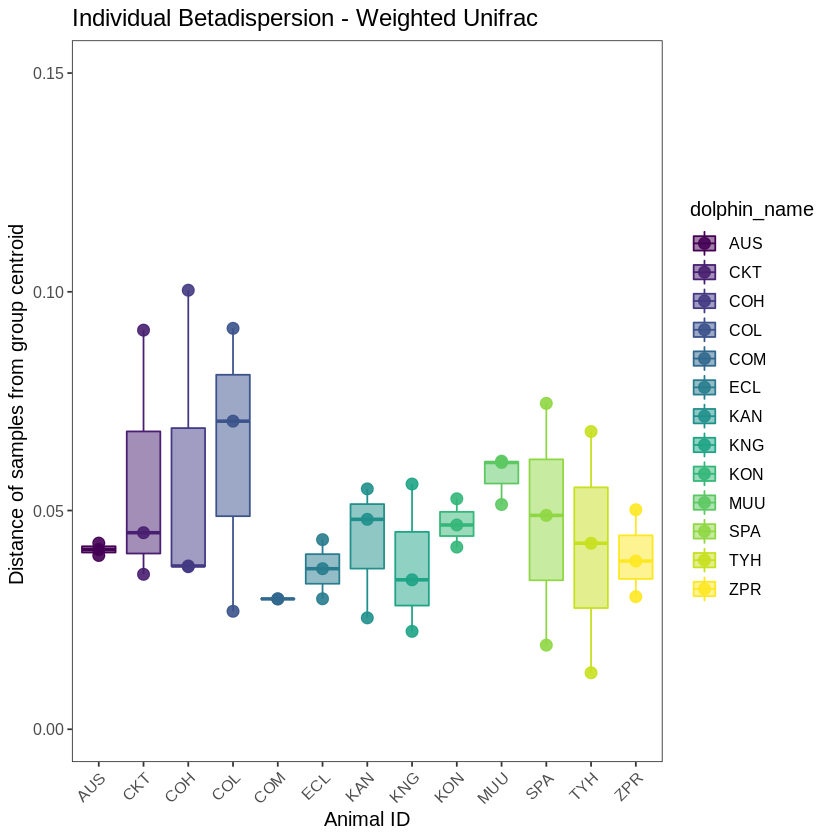

In [277]:
p = ggplot(beta.disp.wuf2, aes(x = dolphin_name, y = d, fill = dolphin_name, color = dolphin_name)) + ggtitle("Individual Betadispersion - Weighted Unifrac")

p = p + geom_boxplot(outlier.stroke = 0.2, outlier.shape=20, alpha = 0.5) + 
        ylab("Distance of samples from group centroid ") + 
        xlab("Animal ID") +
        scale_y_continuous(limits=c(0,0.15)) +
        scale_fill_viridis(discrete=TRUE)
        #scale_fill_manual(values=c("cadetblue1", "cadetblue4"))
        #coord_flip(ylim = c(0,0.15))

p = p + geom_point(size = 3, position = position_jitter(h = 0, w = 0), alpha = 0.9) +
    scale_color_viridis(discrete=TRUE)

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="right",
                           axis.text.x = element_text(angle = 45, hjust=1))
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))

p

png('/home/holutz/projects/DolphinMP/Phase1/Plots/dolphin_name.bdisp.wunif.viridis.png', width=6, height=5, units='in', res=300)
plot(p)
dev.off()

In [239]:
beta.disp.wuf = betadisper(dmp.dist.wunif,group = sample_data(dmp_t)$status)
beta.disp.wuf = beta.disp.wuf$distances
beta.disp.wuf = data.frame(d = beta.disp.wuf, sample_id = names(beta.disp.wuf))
beta.disp.wuf2 = left_join(beta.disp.wuf, sample_tab, by="sample_id")

In [240]:
wuf2.betadisper.kw = kruskal.test(d~status, data=beta.disp.wuf2)
wuf2.betadisper.kw


	Kruskal-Wallis rank sum test

data:  d by status
Kruskal-Wallis chi-squared = 2.2722, df = 1, p-value = 0.1317


png 
  2

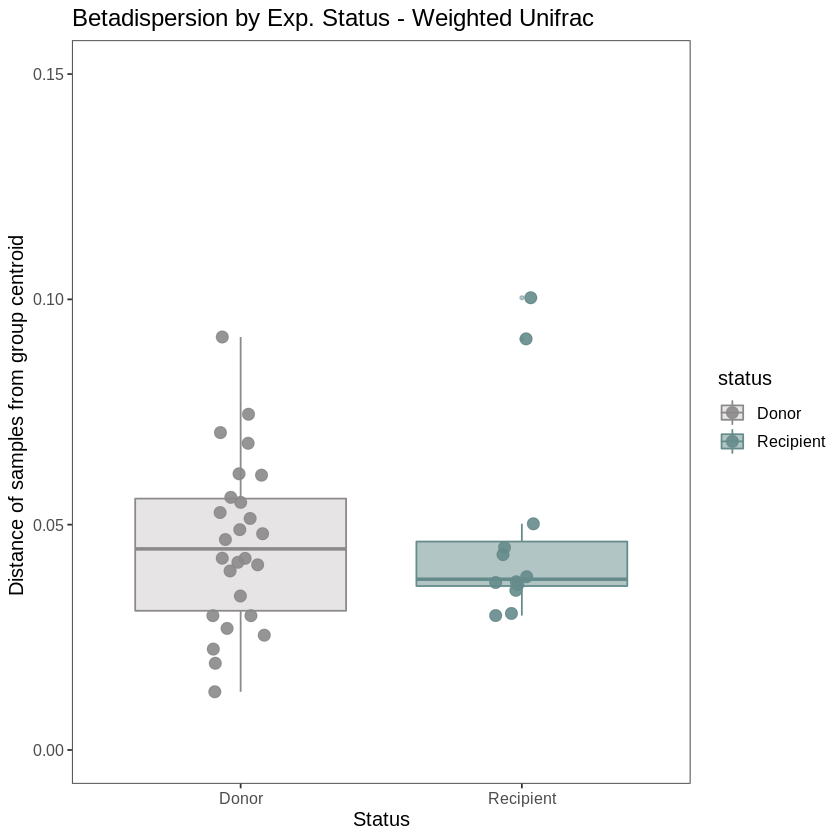

In [298]:
p = ggplot(beta.disp.wuf2, aes(x = status, y = d, fill = status, color = status)) + ggtitle("Betadispersion by Exp. Status - Weighted Unifrac")

p = p + geom_boxplot(outlier.stroke = 0.4, outlier.shape=20, alpha = 0.5) + 
        ylab("Distance of samples from group centroid ") + 
        xlab("Status") +
        scale_y_continuous(limits=c(0,0.15)) +
        scale_fill_manual(values=c("snow3", "paleturquoise4"))
        #coord_flip(ylim = c(0,0.15))

p = p + geom_point(size = 3, position = position_jitter(h = 0, w = 0.1), alpha = 0.9) +
    scale_color_manual(values=c("snow4", "paleturquoise4"))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="right")
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))
p

png('/home/holutz/projects/DolphinMP/Phase1/Plots/status.bdisp.wunif.png', width=6, height=5, units='in', res=300)
plot(p)
dev.off()

#### Unweighted UniFrac

In [345]:
dmp.dist.unif = distance(dmp_t, method = "unifrac", type = "samples")
dmp.dist.unif.log = ordinate(dmp_t, method = "PCoA", distance = "unifrac")
dmp.dist.unif.evals = dmp.dist.unif.log$values$Eigenvalues

sample_tab = (data.frame(sample_data(dmp_t)))

beta.disp.uf = betadisper(dmp.dist.unif,group = sample_data(dmp_t)$dolphin_name)
beta.disp.uf = beta.disp.uf$distances
beta.disp.uf = data.frame(d = beta.disp.uf, sample_id = names(beta.disp.uf))
beta.disp.uf2 = left_join(beta.disp.uf, sample_tab, by="sample_id")

In [ ]:
avg_obs <- aggregate(d ~ dolphin_name, data = beta.disp.uf2, mean)
beta.disp.uf2$dolphin_name <-factor(beta.disp.uf2$dolphin_name, levels=avg_obs[order(avg_obs$d), "dolphin_name"])


In [346]:
uf2.betadisper.kw = kruskal.test(d~dolphin_name, data=beta.disp.uf2)
uf2.betadisper.kw


	Kruskal-Wallis rank sum test

data:  d by dolphin_name
Kruskal-Wallis chi-squared = 7.021, df = 12, p-value = 0.8562


png 
  2

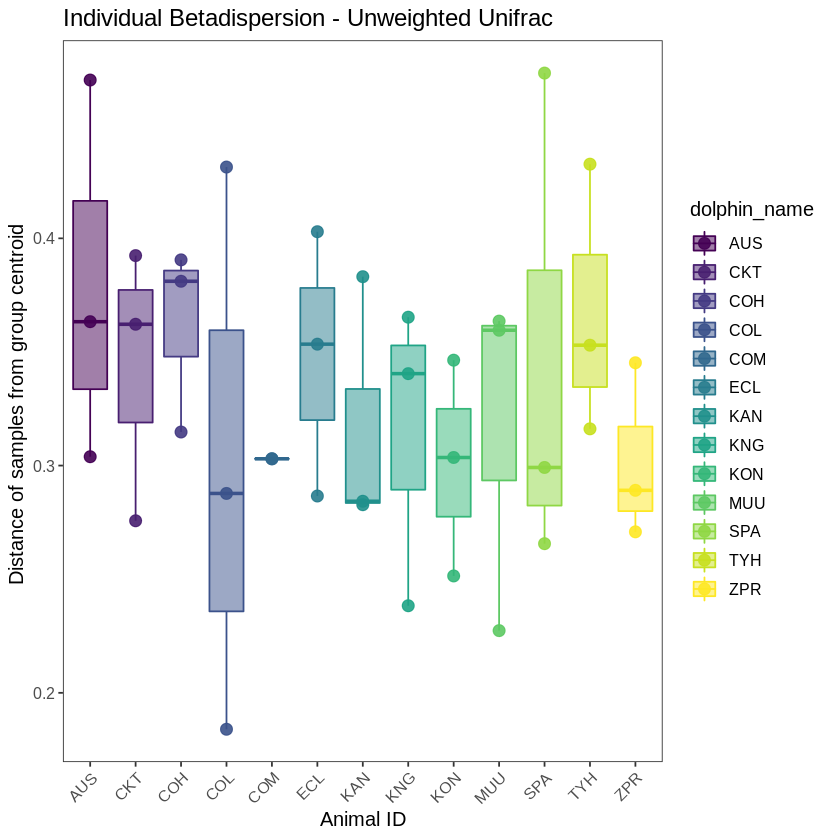

In [347]:
p = ggplot(beta.disp.uf2, aes(x = dolphin_name, y = d, fill = dolphin_name, color = dolphin_name)) + ggtitle("Individual Betadispersion - Unweighted Unifrac")

p = p + geom_boxplot(outlier.stroke = 0.2, outlier.shape=20, alpha = 0.5) + 
        ylab("Distance of samples from group centroid ") + 
        xlab("Animal ID") +
        #scale_y_continuous(limits=c(0,0.15)) +
        scale_fill_viridis(discrete=TRUE)
        #scale_fill_manual(values=c("cadetblue1", "cadetblue4"))
        #coord_flip(ylim = c(0,0.15))

p = p + geom_point(size = 3, position = position_jitter(h = 0, w = 0), alpha = 0.9) +
    scale_color_viridis(discrete=TRUE)

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="right",
                           axis.text.x = element_text(angle = 45, hjust=1))
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))

p

png('/home/holutz/projects/DolphinMP/Phase1/Plots/dolphin_name.bdisp.unif.viridis.png', width=6, height=5, units='in', res=300)
plot(p)
dev.off()

In [348]:
beta.disp.uf = betadisper(dmp.dist.unif,group = sample_data(dmp_t)$status)
beta.disp.uf = beta.disp.uf$distances
beta.disp.uf = data.frame(d = beta.disp.uf, sample_id = names(beta.disp.uf))
beta.disp.uf2 = left_join(beta.disp.uf, sample_tab, by="sample_id")

uf2.betadisper.kw = kruskal.test(d~status, data=beta.disp.uf2)
uf2.betadisper.kw


	Kruskal-Wallis rank sum test

data:  d by status
Kruskal-Wallis chi-squared = 3.9142, df = 1, p-value = 0.04788


png 
  2

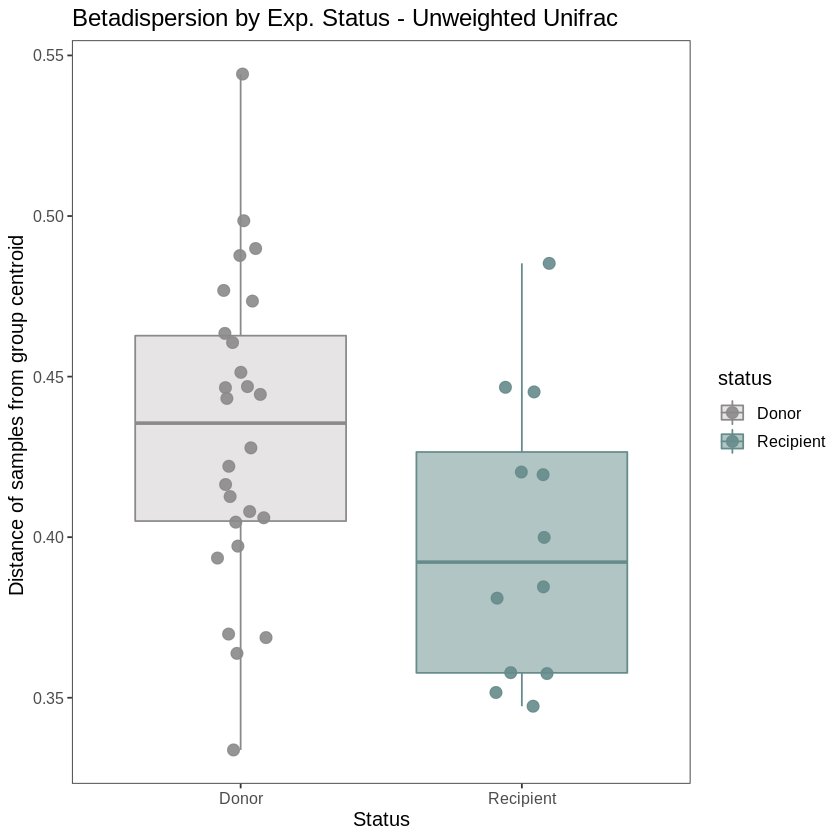

In [350]:
p = ggplot(beta.disp.uf2, aes(x = status, y = d, fill = status, color = status)) + ggtitle("Betadispersion by Exp. Status - Unweighted Unifrac")

p = p + geom_boxplot(outlier.stroke = 0.4, outlier.shape=20, alpha = 0.5) + 
        ylab("Distance of samples from group centroid ") + 
        xlab("Status") +
       # scale_y_continuous(limits=c(0,0.15)) +
        scale_fill_manual(values=c("snow3", "paleturquoise4"))
        #coord_flip(ylim = c(0,0.15))

p = p + geom_point(size = 3, position = position_jitter(h = 0, w = 0.1), alpha = 0.9) +
    scale_color_manual(values=c("snow4", "paleturquoise4"))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="right")
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))
p

png('/home/holutz/projects/DolphinMP/Phase1/Plots/status.bdisp.unif.png', width=6, height=5, units='in', res=300)
plot(p)
dev.off()

#### Weighted UniFrac PCoA and ADONIS

In [243]:
dmp.df = data.frame(sample_data(dmp_t))

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
status,1,0.003798051,0.02435013,0.8984829,0.557
Residual,36,0.152178555,0.97564987,NA,NA
Total,37,0.155976606,1.00000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
dolphin_name,12,0.06407294,0.4107856,1.452448,0.009
Residual,25,0.09190367,0.5892144,NA,NA
Total,37,0.15597661,1.0000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
dolphin_name,12,0.06407294,0.4107856,1.452448,0.006
Residual,25,0.09190367,0.5892144,NA,NA
Total,37,0.15597661,1.0000000,NA,NA


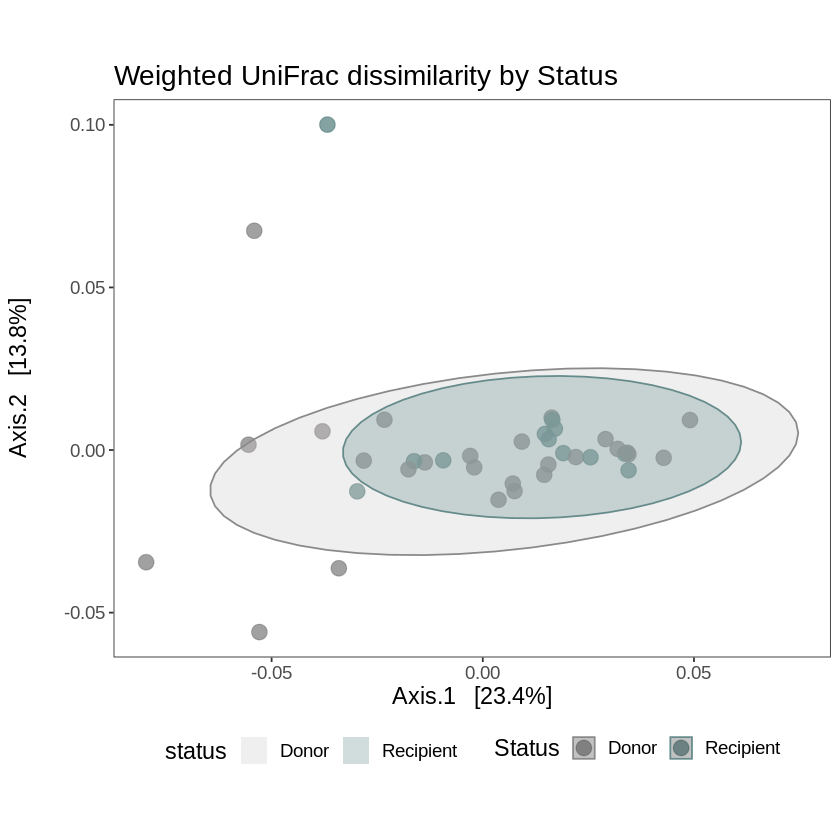

png 
  2

png 
  2

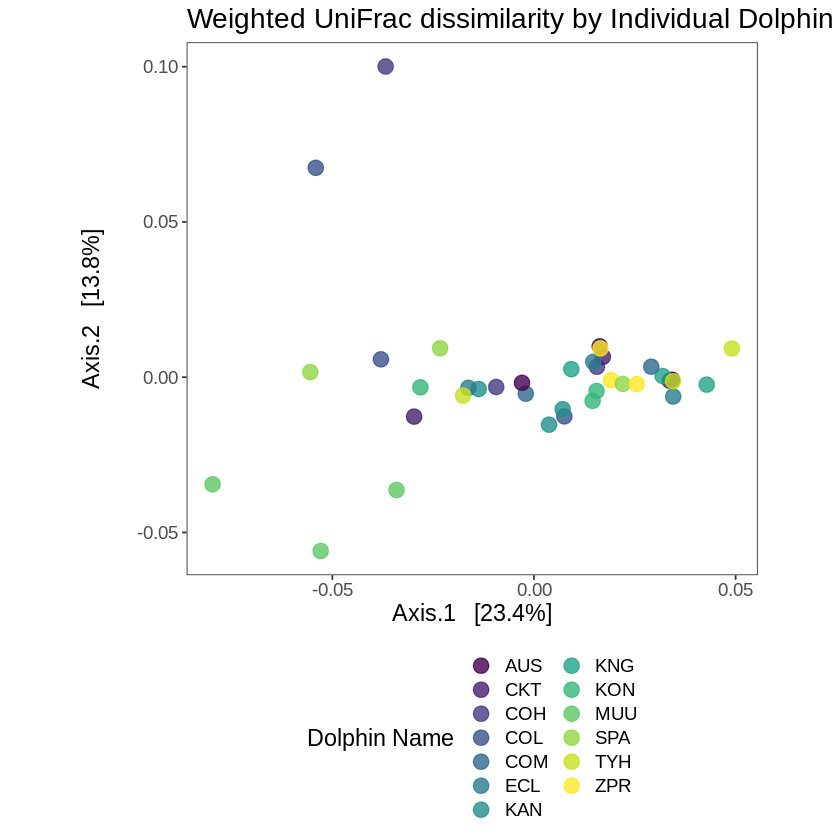

In [344]:
#Estimate dissimilarity
dmp.dist.wunif = distance(dmp_t, method = "wunifrac", type = "samples")
dmp.dist.wunif.log = ordinate(dmp_t, method = "PCoA", distance = "wunifrac")
dmp.dist.wunif.evals = dmp.dist.wunif.log$values$Eigenvalues

#Adonis/PERMANOVA
adonis2(dmp.dist.wunif ~ status, nperm=999, data=dmp.df)
adonis2(dmp.dist.wunif ~ dolphin_name, nperm=999, data=dmp.df)

#Plot
p = plot_ordination(dmp_t, dmp.dist.wunif.log, color = "status") + 
    ggtitle("Weighted UniFrac dissimilarity by Status") + 
    geom_point(size=4, alpha=0.8) + 
    scale_colour_manual(values=c("snow4", "paleturquoise4")) +
    stat_ellipse(level=0.95, geom="polygon",alpha = .3, aes(fill = status), linetype=1) +
    scale_fill_manual(values=c("snow3", "paleturquoise4"))+
    coord_fixed(sqrt(dmp.dist.wunif.evals[2] / dmp.dist.wunif.evals[1]))

p = p + guides(colour = guide_legend(title = "Status", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_bw() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=14, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              legend.position = "bottom")
p$layers <- p$layers[-1]

p

p2 = plot_ordination(dmp_t, dmp.dist.wunif.log, color = "dolphin_name") + 
    ggtitle("Weighted UniFrac dissimilarity by Individual Dolphin") + 
    geom_point(size=4, alpha=0.8) + 
    geom_path(data=dmp_t, aes(x=x, y=y, colour=dolphin_name)
    scale_colour_viridis(discrete=TRUE) +
    coord_fixed(sqrt(dmp.dist.wunif.evals[2] / dmp.dist.wunif.evals[1]))

p2 = p2 + guides(colour = guide_legend(title = "Dolphin Name", ncol = 2, keywidth = 1, keyheight = 1))

p2 = p2 + theme_bw() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=14, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              legend.position = "bottom")

p2$layers <- p2$layers[-1]
p2

#png('/home/holutz/projects/DolphinMP/Phase1/Plots/status.pcoa.wunif.png', width=6, height=5, units='in', res=300)
#plot(p)
#dev.off()


#png('/home/holutz/projects/DolphinMP/Phase1/Plots/dolphin_name.pcoa.wunif.png', width=6, height=5, units='in', res=300)
#plot(p2)
#dev.off()

In [511]:
?geom_polygon

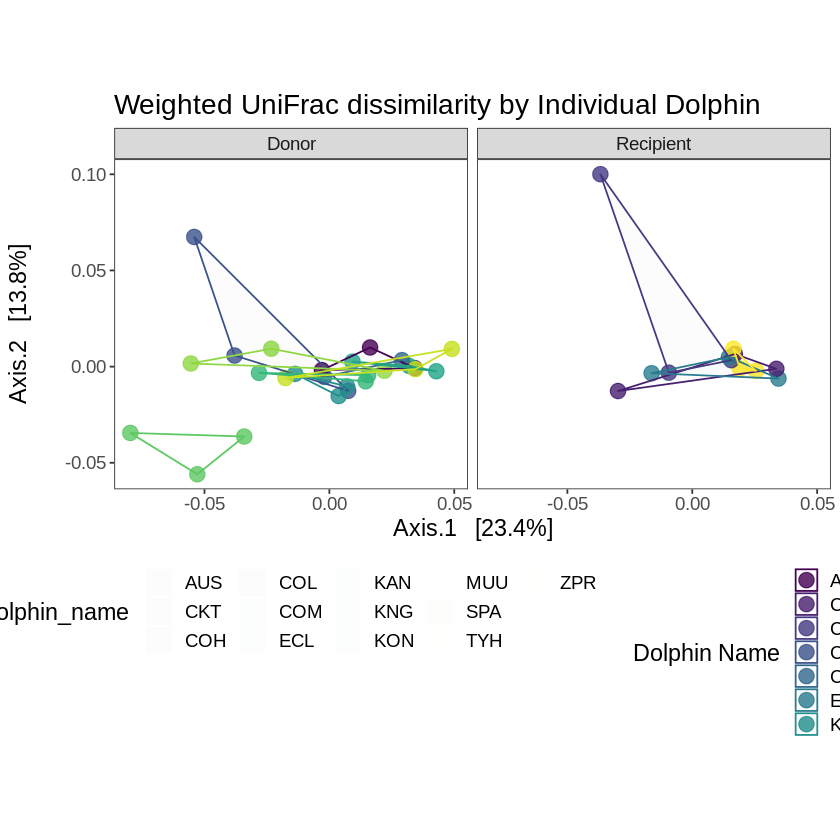

In [521]:
p2 = plot_ordination(dmp_t, dmp.dist.wunif.log, color = "dolphin_name") + 
    ggtitle("Weighted UniFrac dissimilarity by Individual Dolphin") + 
    geom_point(size=4, alpha=0.8) + 
    geom_polygon(aes(fill = dolphin_name), alpha=0.01) +
    scale_colour_viridis(option="viridis", discrete=TRUE) +
    scale_fill_viridis(option="viridis", discrete=TRUE) +
    coord_fixed(sqrt(dmp.dist.wunif.evals[2] / dmp.dist.wunif.evals[1]))

              p2 = p2 + guides(colour = guide_legend(title = "Dolphin Name", ncol = 2, keywidth = 1, keyheight = 1))

p2 = p2 + theme_bw() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=14, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              legend.position = "bottom")

p2$layers <- p2$layers[-1]
p2 = p2 + facet_wrap(~status)
p2



#### Unweighted UniFrac PCoA and Adonis

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
status,1,0.2120518,0.02998454,1.11281,0.262
Residual,36,6.8599861,0.97001546,NA,NA
Total,37,7.0720379,1.00000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
dolphin_name,12,2.804579,0.396573,1.369169,0.002
Residual,25,4.267459,0.603427,NA,NA
Total,37,7.072038,1.000000,NA,NA


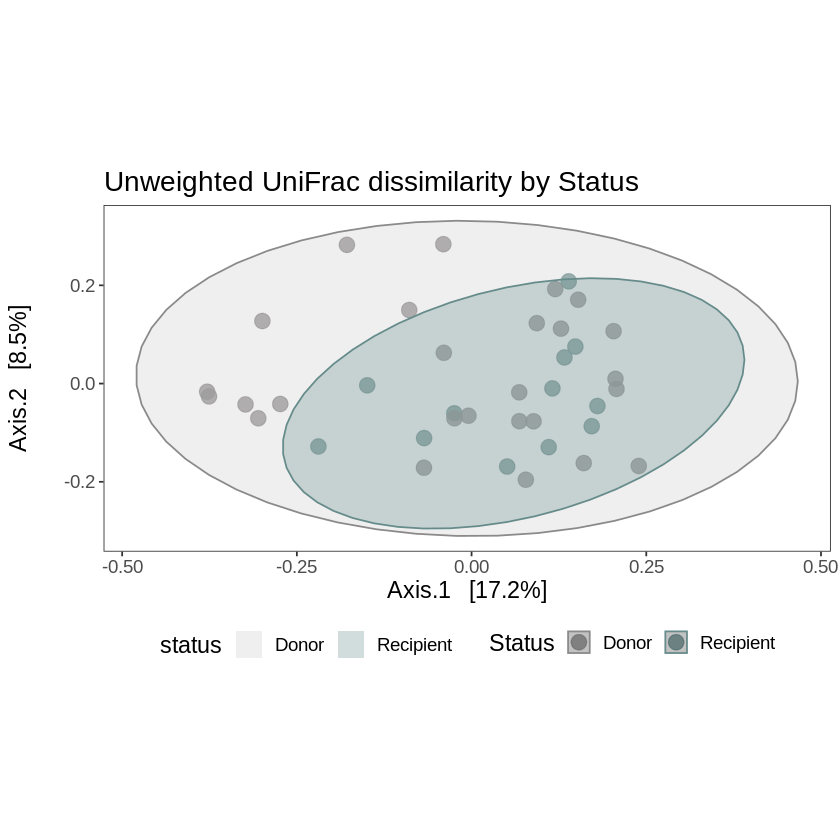

png 
  2

png 
  2

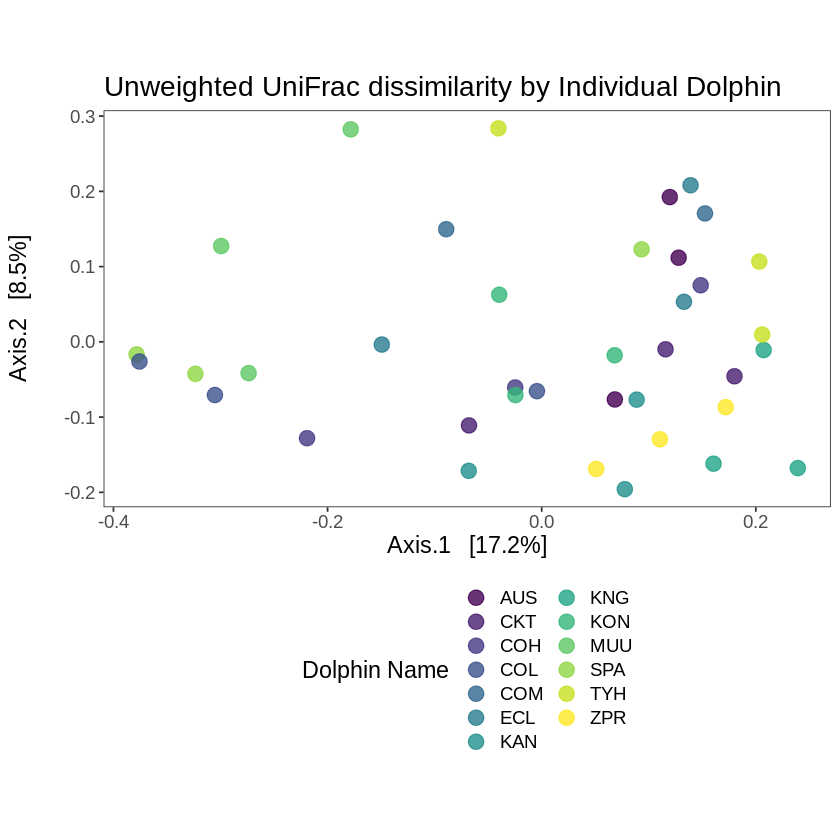

In [300]:
#Estimate dissimilarity
dmp.dist.unif = distance(dmp_t, method = "unifrac", type = "samples")
dmp.dist.unif.log = ordinate(dmp_t, method = "PCoA", distance = "unifrac")
dmp.dist.unif.evals = dmp.dist.unif.log$values$Eigenvalues

#Adonis/PERMANOVA
adonis2(dmp.dist.unif ~ status, nperm=999, data=dmp.df)
adonis2(dmp.dist.unif ~ dolphin_name, nperm=999, data=dmp.df)

#Plot
p = plot_ordination(dmp_t, dmp.dist.unif.log, color = "status") + 
    ggtitle("Unweighted UniFrac dissimilarity by Status") + 
    geom_point(size=4, alpha=0.8) + 
    scale_colour_manual(values=c("snow4", "paleturquoise4")) +
    stat_ellipse(level=0.95, geom="polygon",alpha = .3, aes(fill = status), linetype=1) +
    scale_fill_manual(values=c("snow3", "paleturquoise4"))+
    coord_fixed(sqrt(dmp.dist.unif.evals[2] / dmp.dist.unif.evals[1]))

p = p + guides(colour = guide_legend(title = "Status", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_bw() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=14, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              legend.position = "bottom")

p$layers <- p$layers[-1]
p

p2 = plot_ordination(dmp_t, dmp.dist.unif.log, color = "dolphin_name") + 
    ggtitle("Unweighted UniFrac dissimilarity by Individual Dolphin") + 
    geom_point(size=4, alpha=0.8) + 
    scale_colour_viridis(discrete=TRUE) +
    coord_fixed(sqrt(dmp.dist.unif.evals[2] / dmp.dist.unif.evals[1]))

p2 = p2 + guides(colour = guide_legend(title = "Dolphin Name", ncol = 2, keywidth = 1, keyheight = 1))

p2 = p2 + theme_bw() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=14, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              legend.position = "bottom")

p2$layers <- p2$layers[-1]
p2

png('/home/holutz/projects/DolphinMP/Phase1/Plots/status.pcoa.unif.png', width=6, height=5, units='in', res=300)
plot(p)
dev.off()


png('/home/holutz/projects/DolphinMP/Phase1/Plots/dolphin_name.pcoa.unif.png', width=6, height=5, units='in', res=300)
plot(p2)
dev.off()

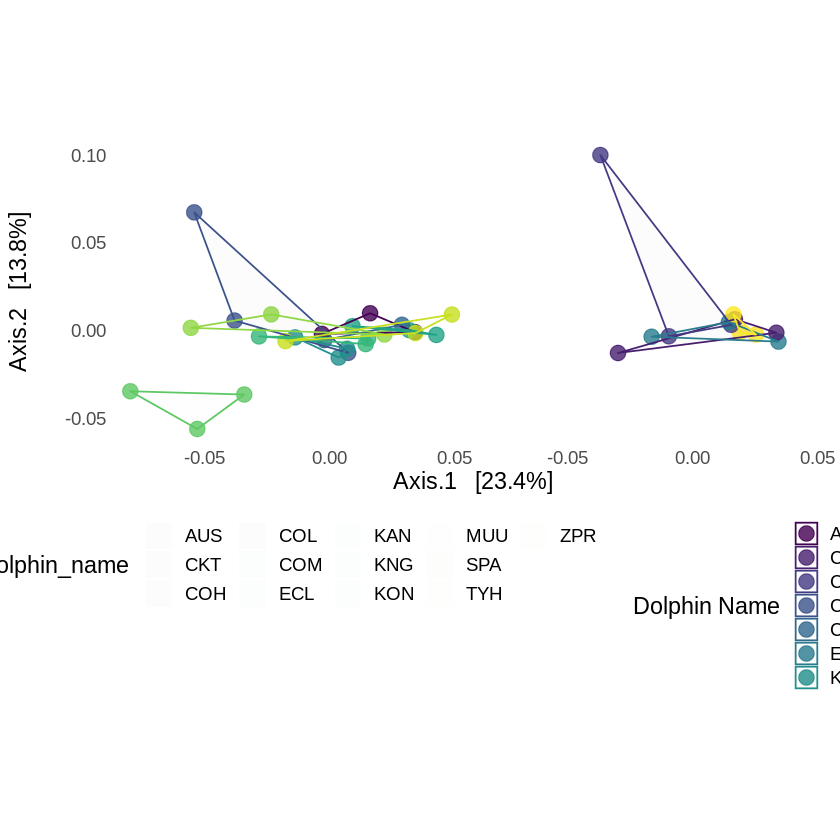

In [530]:
p2 = plot_ordination(dmp_t, dmp.dist.wunif.log, color = "dolphin_name") + 
   # ggtitle("Unweighted UniFrac dissimilarity by Individual Dolphin") + 
    geom_point(size=4, alpha=0.8) + 
    geom_polygon(aes(fill = dolphin_name), alpha=0.01) +
    scale_colour_viridis(option="viridis", discrete=TRUE) +
    scale_fill_viridis(option="viridis", discrete=TRUE) +
    coord_fixed(sqrt(dmp.dist.unif.evals[2] / dmp.dist.unif.evals[1]))

              p2 = p2 + guides(colour = guide_legend(title = "Dolphin Name", ncol = 2, keywidth = 1, keyheight = 1))

p2 = p2 + theme_minimal() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=14, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              strip.text.x = element_blank(),
              legend.position = "bottom")

p2$layers <- p2$layers[-1]
p2 = p2 + facet_wrap(~status, nrow=1)
p2

#png('/home/holutz/projects/DolphinMP/Phase1/Plots/individual.geom.pcoa.unif.png', width=6, height=5, units='in', res=300)
#plot(p2)
#dev.off()

### Relative Abundance

In [375]:
dolphin.t.mdf = readRDS("/home/holutz/projects/DolphinMP/Phase1/MDFfiles/dolphin.t.mdf.rds")

In [385]:
#Replacing unclassified ranks with "other"
dolphin.t.mdf$Rank6 = as.character(dolphin.t.mdf$Rank6)
dolphin.t.mdf$Rank6[which(dolphin.t.mdf$Rank6 == "g__")] = "Other"
dolphin.t.mdf$Rank6 = as.factor(dolphin.t.mdf$Rank6)
head(dolphin.t.mdf$Rank6)

[1] g__Clostridium                g__Candidatus Thiodiazotropha
[3] g__Erysipelatoclostridium     g__Candidatus Thiodiazotropha
[5] g__Photobacterium             g__Clostridium               
869 Levels: g__Abiotrophia g__Acetanaerobacterium ... Other

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Selecting by m

`summarise()` regrouping output by 'Sample', 'status' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



png 
  2

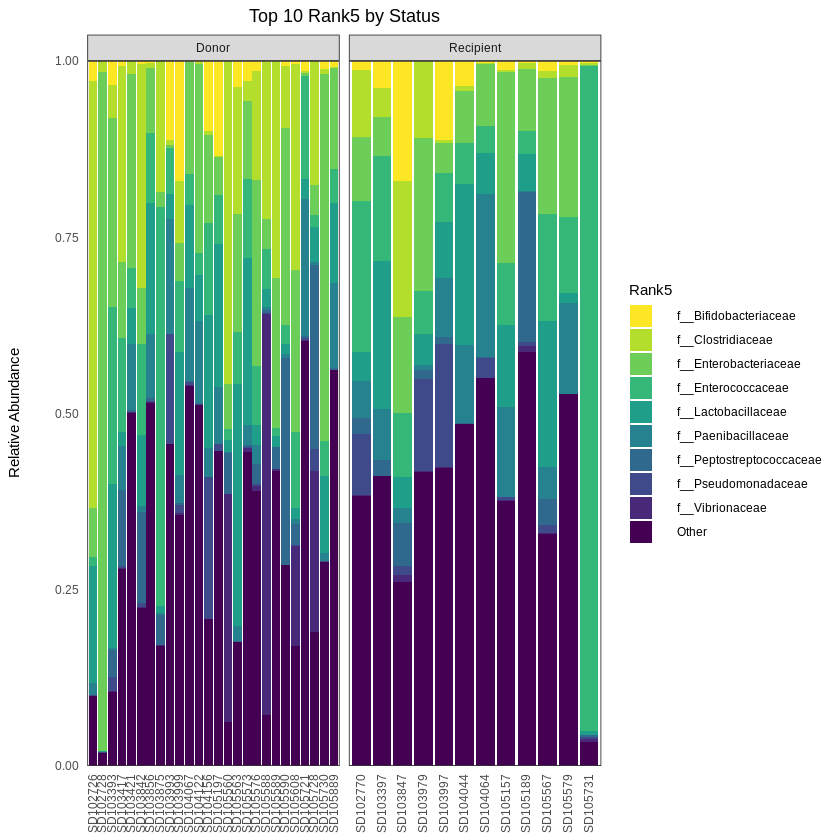

In [405]:
N = 10

topN = dolphin.t.mdf %>%
    group_by(Rank5) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank5) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank5")

mdfall.other = dolphin.t.mdf %>%
    mutate(Rank5.other = ifelse(Rank5 %in% topN, as.character(Rank5), "Other")) %>%
    group_by(Sample, status, Rank5.other) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdfall.summary = mdfall.other %>%
    group_by(Rank5.other) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              abundance = round(avg*100,2)) %>%
    arrange(Rank5.other)

p = ggplot(mdfall.other[order(mdfall.other$Rank5.other),], aes(x=Sample, y = Abundance, fill = Rank5.other))
                        
p = p + facet_wrap(~status, shrink = TRUE, scales = "free_x",nrow=1) +
    ylab("Relative Abundance")  +
    geom_bar(stat="identity") +
    scale_fill_viridis(option="viridis", discrete=TRUE, direction=-1) +
    scale_y_continuous(expand = c(0,0))

p = p + guides(fill = guide_legend(title = "Rank5", ncol = 1, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=9, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              axis.text.x=element_text(angle=90,vjust=0.4),
              #legend.key.size = unit(.25, "mm"),
              legend.spacing.x = unit(.2,"in"),
              axis.title.x=element_blank())

p = p + theme(legend.position="right")

p = p + ggtitle("Top 10 Rank5 by Status") + theme(plot.title = element_text(hjust = 0.5))

p

png('/home/holutz/projects/DolphinMP/Phase1/Plots/RelAbund.Status.Rank5.png', width=10, height=8, units='in', res=300)
plot(p)
dev.off()

#### Fusobacterium specific inquiry

In [501]:
Thio = subset(dolphin.t.mdf, Rank6=="g__Candidatus Thiodiazotropha")
fuso = subset(dolphin.t.mdf, Rank7=="s__Fusobacterium ulcerans")
paen = subset(dolphin.t.mdf, Rank6=="g__Paeniclostridium")

In [423]:
fuso.summary = Fusobacterium %>%
    group_by(status) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              abundance = round(avg*100,2)) %>%
    arrange(status)
fuso.summary

`summarise()` ungrouping output (override with `.groups` argument)



status,avg,sd,sem,abundance
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Donor,0.0004042909,0.001213837,0.0002380531,0.04
Recipient,0.0046991521,0.016241741,0.0046885868,0.47


In [502]:
uf2.betadisper.kw = kruskal.test(Abundance~status, data=fuso)
uf2.betadisper.kw


	Kruskal-Wallis rank sum test

data:  Abundance by status
Kruskal-Wallis chi-squared = 1.5425, df = 1, p-value = 0.2142


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 19 rows containing non-finite values (stat_boxplot).”


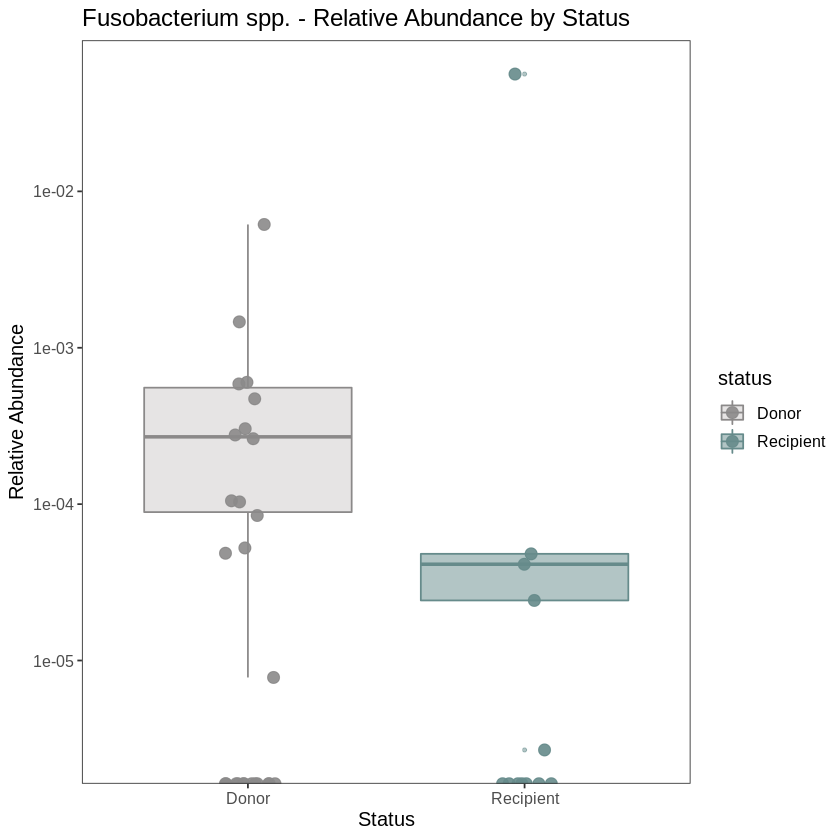

In [503]:
p = ggplot(fuso, aes(x = status, y = Abundance, fill = status, color = status)) + ggtitle("Fusobacterium spp. - Relative Abundance by Status")

p = p + geom_boxplot(outlier.stroke = 0.4, outlier.shape=20, alpha = 0.5) + 
        ylab("Relative Abundance") + 
        xlab("Status") +
        scale_y_continuous(trans='log10') +
        scale_fill_manual(values=c("snow3", "paleturquoise4"))
        #coord_flip(ylim = c(0,0.15))

p = p + geom_point(size = 3, position = position_jitter(h = 0, w = 0.1), alpha = 0.9) +
    scale_color_manual(values=c("snow4", "paleturquoise4"))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="right")
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))
p

#png('/home/holutz/projects/DolphinMP/Phase1/Plots/status.bdisp.unif.png', width=6, height=5, units='in', res=300)
#plot(p)
#dev.off()

In [549]:
uf2.betadisper.kw = kruskal.test(Abundance~status, data=Cperf)
uf2.betadisper.kw


	Kruskal-Wallis rank sum test

data:  Abundance by status
Kruskal-Wallis chi-squared = 0.88757, df = 1, p-value = 0.3461


In [548]:
Cperf = subset(dolphin.t.mdf, Rank7=="s__Clostridium perfringens")



Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 2454 rows containing non-finite values (stat_boxplot).”


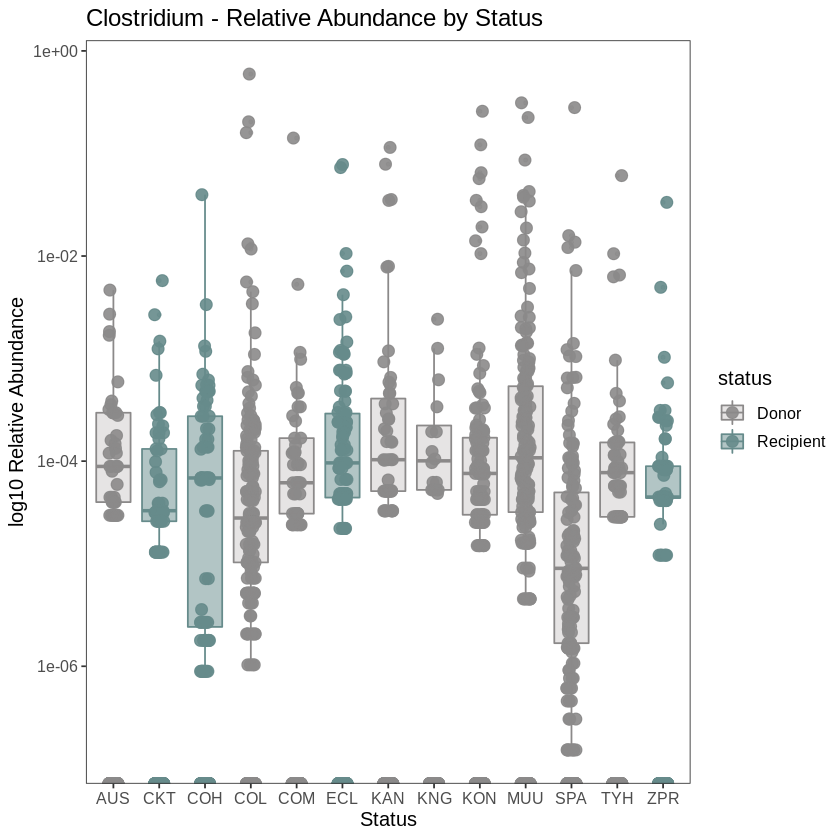

In [552]:
p = ggplot(Clostridium, aes(x = dolphin_name, y = Abundance, fill = status, color = status)) + ggtitle("Clostridium - Relative Abundance by Status")

p = p + geom_boxplot(outlier.stroke = 0.4, outlier.shape=20, alpha = 0.5) + 
        ylab("log10 Relative Abundance") + 
        xlab("Status") +
        scale_y_continuous(trans='log10') +
        scale_fill_manual(values=c("snow3", "paleturquoise4"))
        #coord_flip(ylim = c(0,0.15))

p = p + geom_point(size = 3, position = position_jitter(h = 0, w = 0.1), alpha = 0.9) +
    scale_color_manual(values=c("snow4", "paleturquoise4"))

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="right")
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))
p

#png('/home/holutz/projects/DolphinMP/Phase1/Plots/status.bdisp.unif.png', width=6, height=5, units='in', res=300)
#plot(p)
#dev.off()

#### Alphadiversity

In [334]:
obs = estimate_richness(dmp_nt, split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)
obs[] <- lapply(obs, gsub, pattern='X', replacement='') #Remove X from SampleID name

sample_tab = data.frame(sample_data(dmp_nt))
names(sample_tab)[1] = "SampleID"

dfobs = merge(obs, sample_tab, on="SampleID")

dfobs$Observed = as.numeric(dfobs$Observed)

stats = dfobs %>%
    group_by(status) %>%
    summarize(median = median(Observed),
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) %>%
    arrange(-desc(mean))
stats

stats.krusk = kruskal.test(Observed~status, data=dfobs)
stats.krusk

`summarise()` ungrouping output (override with `.groups` argument)



status,median,mean,sd,sem
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Recipient,596,627.5833,154.0587,44.47292
Donor,662,741.0385,321.8043,63.11103



	Kruskal-Wallis rank sum test

data:  Observed by status
Kruskal-Wallis chi-squared = 0.22189, df = 1, p-value = 0.6376


png 
  2

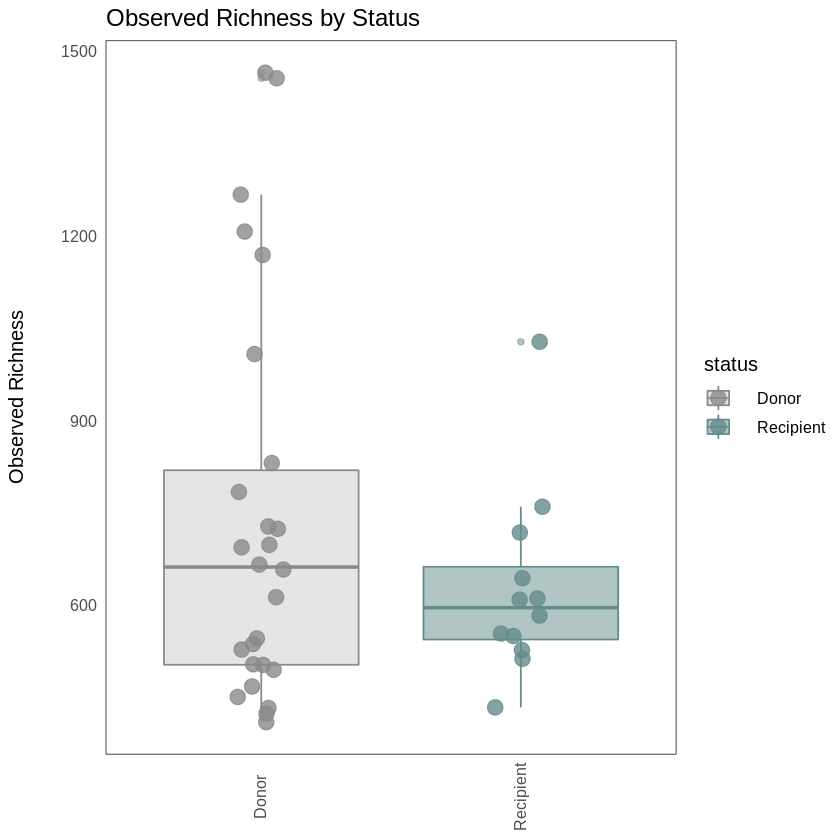

In [335]:
p = ggplot(dfobs, aes(x = status, y = Observed, fill=status, color=status)) + ggtitle("Observed Richness by Status")

p = p + geom_boxplot(alpha = 0.5) + ylab("Observed Richness") +
    scale_fill_manual(values=c("snow3", "paleturquoise4"))
    

p = p + geom_point(size = 4, position = position_jitter(h = 0, w = 0.1), alpha = 0.8) +
    scale_color_manual(values=c("snow4", "paleturquoise4"))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=12, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              axis.text.x=element_text(angle=90,vjust=0.4),
              #legend.key.size = unit(.25, "mm"),
              legend.spacing.x = unit(.2,"in"),
              axis.title.x=element_blank())
p

png('/home/holutz/projects/DolphinMP/Phase1/Plots/ObservedRichness.status.boxplot.png', width=6, height=6, units='in', res=300)
plot(p)
dev.off()

In [332]:
sha = estimate_richness(dmp_nt, split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)
sha[] <- lapply(sha, gsub, pattern='X', replacement='') #Remove X from SampleID name

sample_tab = data.frame(sample_data(dmp_nt))
names(sample_tab)[1] = "SampleID"

dfsha = merge(sha, sample_tab, on="SampleID")

dfsha$Shannon = as.numeric(dfsha$Shannon)

stats = dfsha %>%
    group_by(status) %>%
    summarize(median = median(Shannon),
              mean = mean(Shannon),
              sd = sd(Shannon),
              sem = sd(Shannon/sqrt(length(Shannon)))) %>%
    arrange(-desc(mean))
stats

stats.krusk = kruskal.test(Shannon~status, data=dfsha)
stats.krusk

`summarise()` ungrouping output (override with `.groups` argument)



status,median,mean,sd,sem
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Donor,3.460145,3.352941,0.5817477,0.1140901
Recipient,3.443106,3.379173,0.6129196,0.1769346



	Kruskal-Wallis rank sum test

data:  Shannon by status
Kruskal-Wallis chi-squared = 0, df = 1, p-value = 1


png 
  2

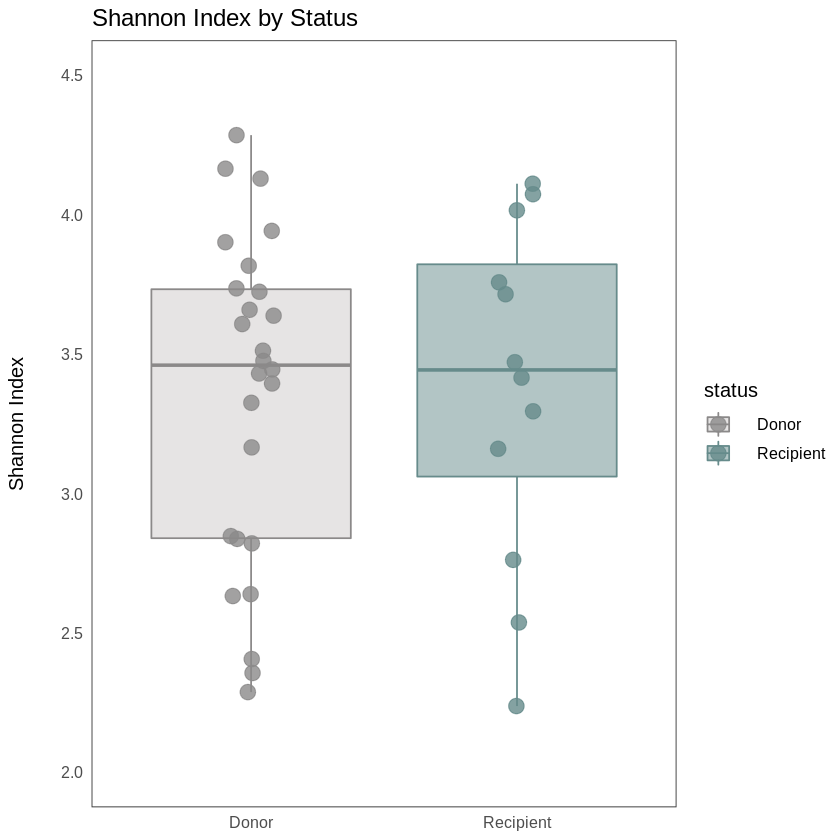

In [333]:
p = ggplot(dfsha, aes(x = status, y = Shannon, fill=status, color=status)) + ggtitle("Shannon Index by Status")

p = p + geom_boxplot(alpha = 0.5) + ylab("Shannon Index") +
    scale_fill_manual(values=c("snow3", "paleturquoise4")) +
    scale_y_continuous(limits=c(2,4.5))

p = p + geom_point(size = 4, position = position_jitter(h = 0, w = 0.1), alpha = 0.8) +
    scale_color_manual(values=c("snow4", "paleturquoise4"))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=12, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              #axis.text.x=element_text(angle=90,hjust=1),
              #legend.key.size = unit(.25, "mm"),
              legend.spacing.x = unit(.2,"in"),
              axis.title.x=element_blank())
p

png('/home/holutz/projects/DolphinMP/Phase1/Plots/ShannonIndex.status.boxplot.png', width=6, height=6, units='in', res=300)
plot(p)
dev.off()

In [336]:
### Observed Richness by Individual Dolphin

obs = estimate_richness(dmp_nt, split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)
obs[] <- lapply(obs, gsub, pattern='X', replacement='') #Remove X from SampleID name

sample_tab = data.frame(sample_data(dmp_nt))
names(sample_tab)[1] = "SampleID"

dfobs = merge(obs, sample_tab, on="SampleID")

dfobs$Observed = as.numeric(dfobs$Observed)

stats = dfobs %>%
    group_by(dolphin_name) %>%
    summarize(median = median(Observed),
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) %>%
    arrange(-desc(mean))
stats

`summarise()` ungrouping output (override with `.groups` argument)



dolphin_name,median,mean,sd,sem
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
KNG,468.0,474.0000,26.51415,15.30795
TYH,495.0,485.3333,48.23208,27.84680
AUS,424.0,509.3333,160.07915,92.42174
CKT,583.0,569.0000,50.47772,29.14332
ECL,554.0,582.6667,164.87975,95.19337
KAN,613.0,626.0000,96.16132,55.51877
ZPR,644.0,637.3333,84.19818,48.61184
COM,667.5,667.5000,231.22392,163.50000
KON,724.0,684.6667,123.77937,71.46405


In [337]:
stats.krusk = kruskal.test(Observed~dolphin_name, data=dfobs)
stats.krusk

dunn = dunn.test(dfobs$Observed, g=dfobs$dolphin_name, method="bonferroni")
dunn


	Kruskal-Wallis rank sum test

data:  Observed by dolphin_name
Kruskal-Wallis chi-squared = 21.999, df = 12, p-value = 0.03753


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 21.9987, df = 12, p-value = 0.04


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |        AUS        CKT        COH        COL        COM        ECL
---------+------------------------------------------------------------------
     CKT |  -0.697982
         |     1.0000
         |
     COH |  -1.285757  -0.587774
         |     1.0000     1.0000
         |
     COL |  -2.644986  -1.947003  -1.359228
         |     0.3186     1.0000     1.0000
         |
     COM |  -1.084300  -0.460006   0.065715   1.281446
         |     1.0000     1.0000     1.0000     1.0000
         |
     ECL |  -0.808190  -0.110207   0.477566   1.836795   0.361433
         |     1.0000     1.0000     1.0000     1.0000     1.0000
         |
     KAN |  -1.249021  -0.551038   0.036735   1.395964  -0.032857 

$chi2
[1] 21.99865

$Z
 [1] -0.69798244 -1.28575713 -0.58777469 -2.64498609 -1.94700365 -1.35922896
 [7] -1.08430093 -0.46000645  0.06571521  1.28144655 -0.80819019 -0.11020775
[13]  0.47756693  1.83679590  0.36143364 -1.24902121 -0.55103877  0.03673592
[19]  1.39596488 -0.03285760 -0.44083102  0.29388734  0.99186978  1.57964447
[25]  2.93887343  1.34716176  1.10207754  1.54290855 -1.61638039 -0.91839795
[31] -0.33062326  1.02860570 -0.36143364 -0.80819019 -0.36735918 -1.91026773
[37] -2.27762691 -1.57964447 -0.99186978  0.36735918 -0.95287051 -1.46943672
[43] -1.02860570 -2.57151425 -0.66124652 -2.46130650 -1.76332406 -1.17554937
[49]  0.18367959 -1.11715853 -1.65311631 -1.21228529 -2.75519384 -0.84492611
[55] -0.18367959  0.18367959  0.88166203  1.46943672  2.82866568  1.24858895
[61]  0.99186978  1.43270080 -0.11020775  1.80005998  2.46130650  2.64498609
[67] -1.28575713 -0.58777469  0.00000000  1.35922896 -0.06571521 -0.47756693
[73] -0.03673592 -1.57964447  0.33062326  0.99186978  1.17554937 -1.46943672

$P
 [1] 0.242594088 0.099263919 0.278341768 0.004084714 0.025767149 0.087037023
 [7] 0.139115697 0.322755794 0.473802282 0.100018431 0.209490551 0.456122307
[13] 0.316479235 0.033120016 0.358887651 0.105828658 0.290803549 0.485347785
[19] 0.081362535 0.486894071 0.329667669 0.384421995 0.160630525 0.057094155
[25] 0.001647038 0.088964071 0.135213982 0.061426483 0.053006048 0.179205282
[31] 0.370464537 0.151832499 0.358887651 0.209490551 0.356675558 0.028049375
[37] 0.011374408 0.057094155 0.160630525 0.356675558 0.170327841 0.070857187
[43] 0.151832499 0.005062742 0.254227115 0.006921602 0.038922925 0.119887498
[49] 0.427132411 0.131963274 0.049153598 0.112701596 0.002932869 0.199076047
[55] 0.427132411 0.427132411 0.188979800 0.070857187 0.002337125 0.105907729
[61] 0.160630525 0.075971681 0.456122307 0.035925584 0.006921602 0.004084714
[67] 0.099263919 0.278341768 0.500000000 0.087037023 0.473802282 0.316479235
[73] 0.485347785 0.057094155 0.370464537 0.160630525 0.119887498 0.070857187

$P.adjusted
 [1] 1.0000000 1.0000000 1.0000000 0.3186077 1.0000000 1.0000000 1.0000000
 [8] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
[15] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
[22] 1.0000000 1.0000000 1.0000000 0.1284689 1.0000000 1.0000000 1.0000000
[29] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
[36] 1.0000000 0.8872038 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
[43] 1.0000000 0.3948939 1.0000000 0.5398850 1.0000000 1.0000000 1.0000000
[50] 1.0000000 1.0000000 1.0000000 0.2287638 1.0000000 1.0000000 1.0000000
[57] 1.0000000 1.0000000 0.1822957 1.0000000 1.0000000 1.0000000 1.0000000
[64] 1.0000000 0.5398850 0.3186077 1.0000000 1.0000000 1.0000000 1.0000000
[71] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000
[78] 1.0000000

$comparisons
 [1] "AUS - CKT" "AUS - COH" "CKT - COH" "AUS - COL" "CKT - COL" "COH - COL"
 [7] "AUS - COM" "CKT - COM" "COH - COM" "COL - COM" "AUS - ECL" "CKT - ECL"
[13] "COH - ECL" "COL - ECL" "COM - ECL" "AUS - KAN" "CKT - KAN" "COH - KAN"
[19] "COL - KAN" "COM - KAN" "ECL - KAN" "AUS - KNG" "CKT - KNG" "COH - KNG"
[25] "COL - KNG" "COM - KNG" "ECL - KNG" "KAN - KNG" "AUS - KON" "CKT - KON"
[31] "COH - KON" "COL - KON" "COM - KON" "ECL - KON" "KAN - KON" "KNG - KON"
[37] "AUS - MUU" "CKT - MUU" "COH - MUU" "COL - MUU" "COM - MUU" "ECL - MUU"
[43] "KAN - MUU" "KNG - MUU" "KON - MUU" "AUS - SPA" "CKT - SPA" "COH - SPA"
[49] "COL - SPA" "COM - SPA" "ECL - SPA" "KAN - SPA" "KNG - SPA" "KON - SPA"
[55] "MUU - SPA" "AUS - TYH" "CKT - TYH" "COH - TYH" "COL - TYH" "COM - TYH"
[61] "ECL - TYH" "KAN - TYH" "KNG - TYH" "KON - TYH" "MUU - TYH" "SPA - TYH"
[67] "AUS - ZPR" "CKT - ZPR" "COH - ZPR" "COL - ZPR" "COM - ZPR" "ECL - ZPR"
[73] "KAN - ZPR" "KNG - ZPR" "KON - ZPR" "MUU - ZPR" "SPA - ZPR" "TYH - ZPR"

In [338]:
avg_obs <- aggregate(Observed ~ dolphin_name, data = dfobs, mean)
dfobs$dolphin_name <-factor(dfobs$dolphin_name, levels=avg_obs[order(avg_obs$Observed), "dolphin_name"])


png 
  2

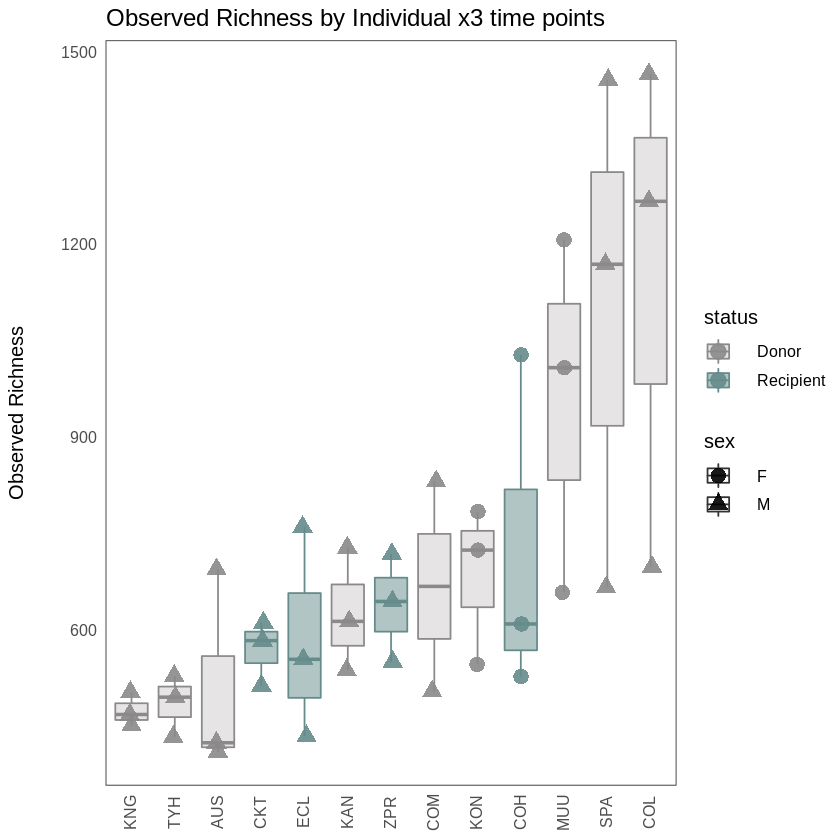

In [339]:
p = ggplot(dfobs, aes(x = dolphin_name, y = Observed, fill=status, color=status, shape = sex)) + ggtitle("Observed Richness by Individual x3 time points")

p = p + geom_boxplot(alpha = 0.5) + ylab("Observed Richness") +
    scale_fill_manual(values=c("snow3", "paleturquoise4"))

p = p + geom_point(size = 4, position = position_jitter(h = 0, w = 0.05), alpha = 0.9) +
    scale_color_manual(values=c("snow4", "paleturquoise4"))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=12, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              axis.text.x=element_text(angle=90,vjust=0.4),
              #legend.key.size = unit(.25, "mm"),
              legend.spacing.x = unit(.2,"in"),
              axis.title.x=element_blank())
p

png('/home/holutz/projects/DolphinMP/Phase1/Plots/ObservedRichness.dolphin_name.boxplot.png', width=6, height=6, units='in', res=300)
plot(p)
dev.off()

In [340]:
### Shannon Index by Individual Dolphin

sha = estimate_richness(dmp_nt, split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)
sha[] <- lapply(sha, gsub, pattern='X', replacement='') #Remove X from SampleID name

sample_tab = data.frame(sample_data(dmp_nt))
names(sample_tab)[1] = "SampleID"

dfsha = merge(sha, sample_tab, on="SampleID")

dfsha$Shannon = as.numeric(dfsha$Shannon)

stats = dfsha %>%
    group_by(dolphin_name) %>%
    summarize(median = median(Shannon),
              mean = mean(Shannon),
              sd = sd(Shannon),
              sem = sd(Shannon/sqrt(length(Shannon)))) %>%
    arrange(-desc(mean))
stats

`summarise()` ungrouping output (override with `.groups` argument)



dolphin_name,median,mean,sd,sem
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
COL,2.632525,2.608825,0.2412235,0.13927047
SPA,2.406533,2.810059,0.8036789,0.46400420
COH,3.294835,3.202011,0.9210222,0.53175239
TYH,3.430260,3.295050,0.3977447,0.22963798
MUU,3.394496,3.325113,0.6538903,0.37752376
CKT,3.415327,3.348823,0.1656495,0.09563779
AUS,3.444865,3.389026,0.5420393,0.31294653
ZPR,3.714488,3.422532,0.7809196,0.45086415
ECL,3.757156,3.543326,0.6992349,0.40370345


In [324]:
stats.krusk = kruskal.test(Shannon~dolphin_name, data=dfsha)
stats.krusk


	Kruskal-Wallis rank sum test

data:  Shannon by dolphin_name
Kruskal-Wallis chi-squared = 11.949, df = 12, p-value = 0.4498


In [341]:
avg_sha <- aggregate(Shannon ~ dolphin_name, data = dfsha, mean)
dfsha$dolphin_name <-factor(dfsha$dolphin_name, levels=avg_sha[order(avg_sha$Shannon), "dolphin_name"])


png 
  2

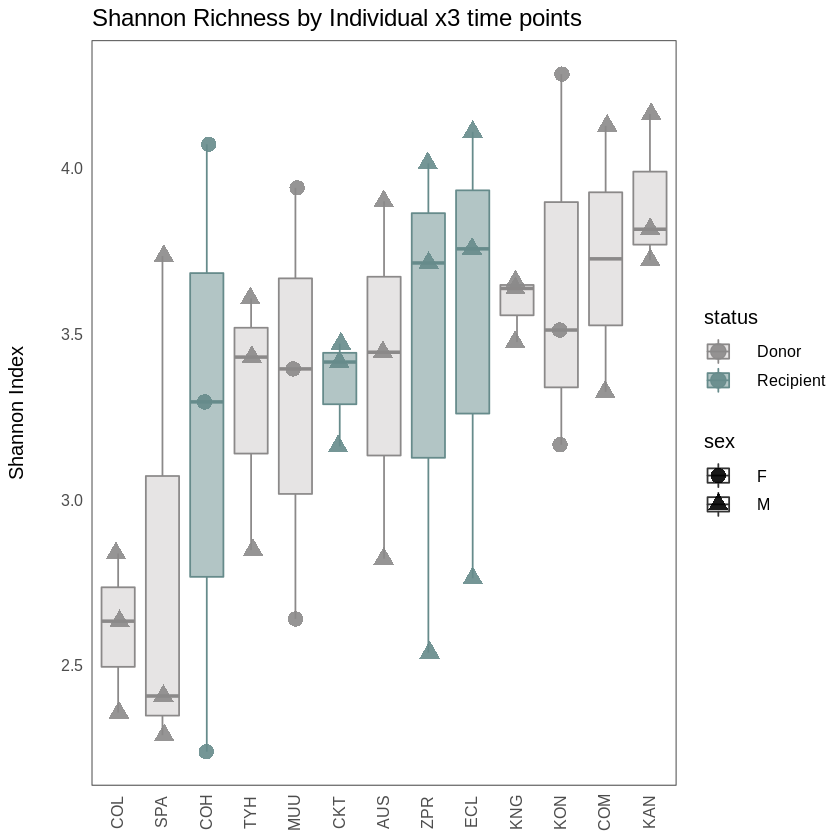

In [342]:
p = ggplot(dfsha, aes(x = dolphin_name, y = Shannon, fill=status, color=status, shape = sex)) + ggtitle("Shannon Richness by Individual x3 time points")

p = p + geom_boxplot(alpha = 0.5) + ylab("Shannon Index") +
    scale_fill_manual(values=c("snow3", "paleturquoise4"))

p = p + geom_point(size = 4, position = position_jitter(h = 0, w = 0.05), alpha = 0.9) +
    scale_color_manual(values=c("snow4", "paleturquoise4"))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=12, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              axis.text.x=element_text(angle=90,vjust=0.4),
              #legend.key.size = unit(.25, "mm"),
              legend.spacing.x = unit(.2,"in"),
              axis.title.x=element_blank())
p

png('/home/holutz/projects/DolphinMP/Phase1/Plots/ShannonIndex.dolphin_name.boxplot.png', width=6, height=6, units='in', res=300)
plot(p)
dev.off()

#### Sea Lion exploration

In [23]:
lion = read.csv("/home/holutz/projects/DolphinMP/Species_taxonomy.relabund.csv")
lion.500read = subset(lion, Reads>=500)
lion.100read = subset(lion, Reads>=100)

In [61]:
lion.100read %>% group_by(Rank7) %>% summarize(percent = sum(PercentRelAbundance)) %>% arrange(-percent)

`summarise()` ungrouping output (override with `.groups` argument)



Rank7,percent
<fct>,<dbl>
s__Lactobacillus gasseri,15.410
s__Lactobacillus salivarius,12.829
s__Escherichia coli,7.951
s__Bifidobacterium pseudolongum,6.793
s__Lactobacillus fermentum,6.301
s__Mycobacterium sp. Root265,4.395
s__Lactobacillus intestinalis,3.939
s__Chlamydia psittaci,3.811
s__Lactobacillus murinus,3.255


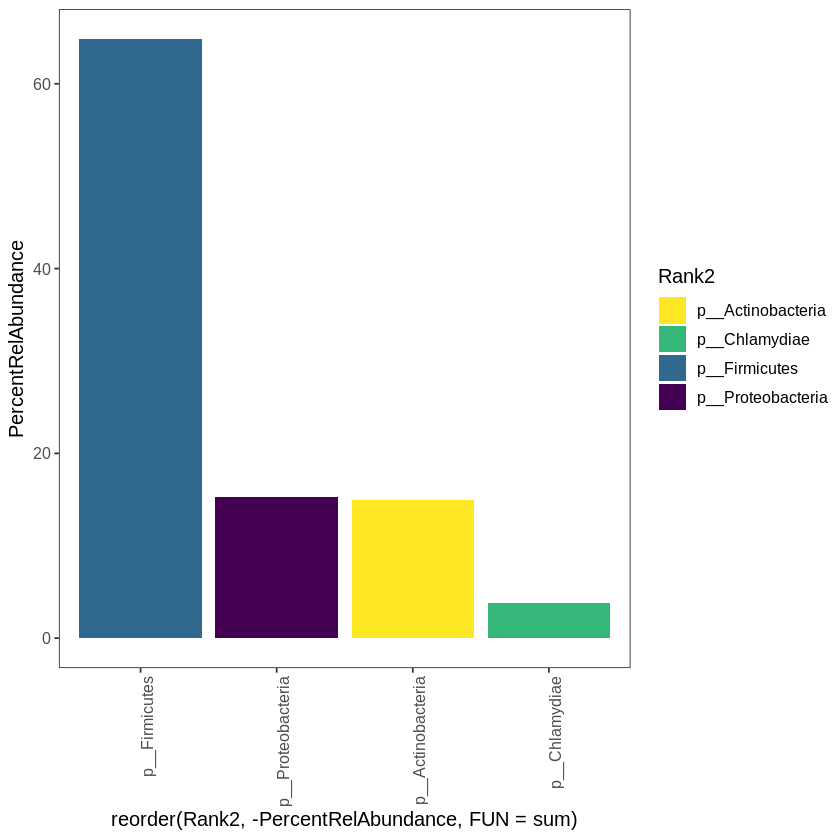

In [60]:
lion.top = subset(lion, Rank2=="p__Actinobacteria" | Rank2=="p__Chlamydiae" | Rank2=="p__Firmicutes" | Rank2=="p__Proteobacteria")

p = ggplot(data=lion.top, aes(x=reorder(Rank2,-PercentRelAbundance, FUN=sum), y=PercentRelAbundance, fill = Rank2)) +
  geom_bar(stat="identity") 


p = p + scale_fill_viridis(option="viridis", discrete=TRUE, direction=-1)

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="right",
                           axis.text.x = element_text(angle = 90, hjust=1))
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))

#p = p + guides(fill=guide_legend(ncol=1,byrow=TRUE))

p
#png('/home/holutz/projects/DolphinMP/SeaLion_topTaxa_fam.png', width=6, height=5, units='in', res=300)
#plot(p)
#dev.off()

### Phase2

In [128]:
biom <- import_biom("/home/holutz/projects/DolphinMP/Phase2/139004_none_WoL_perGenome.biom")

taxonomy <- as.matrix(read.table("/home/holutz/projects/DolphinMP/Phase2/139004_perGenome_taxonomy.txt", sep="\t", row.names = 1,header=TRUE, as.is=TRUE))
taxa <- tax_table(taxonomy)

map <- import_qiime_sample_data("/home/holutz/projects/DolphinMP/Phase2/DolphinOnly_metadata.txt")
tree <- read_tree("/home/holutz/projects/DolphinMP/Phase2/WoL_tree.nwk")
dolphin2_nt <- merge_phyloseq(biom,taxa,tree,map)

#FILTER DATA
dolphin2_nt <- prune_samples((sample_sums(dolphin2_nt) > 1000), dolphin2_nt)

#TRANSFORM DATA
dmp_t <- prune_samples((sample_sums(dolphin2_nt) > 1000), dolphin2_nt) %>%
    transform_sample_counts(function(x) x / sum(x))

In [26]:
sample_tab = data.frame(sample_data(dmp_t))

In [27]:
head(sample_tab)

,sample_id,Date,Dolphin_name,Animal_ID,Sample_number,Duplicate,Status,Age_years,Mass_lb,Sex,Phase,Exp_status
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
SD103393,SD103393,2/11/20,KAN,Dolphin G,Baseline_1,No,Donor,15,434,M,One,Donor_302
SD103842,SD103842,2/27/20,KON,Dolphin I,Baseline_2,No,Donor,46,388,F,One,Donor_302
SD103847,SD103847,2/27/20,COH,Dolphin C,Baseline_1,No,Recipient,36,388,F,One,Recipient_P1
SD102726,SD102726,1/14/20,COL,Dolphin D,Baseline_1,No,Donor,19,531,M,One,Donor_122
SD103979,SD103979,3/6/20,ECL,Dolphin F,Baseline_2,No,Recipient,6,358,M,One,Recipient_P1
SD102770,SD102770,1/16/20,ECL,Dolphin F,Baseline_1,No,Recipient,6,358,M,One,Recipient_P1


In [38]:
dmp.dist.wunif = distance(dmp_t, method = "wunifrac", type = "samples")
dmp.dist.wunif.log = ordinate(dmp_t, method = "PCoA", distance = "wunifrac")
dmp.dist.wunif.evals = dmp.dist.wunif.log$values$Eigenvalues

sample_tab = (data.frame(sample_data(dmp_t)))

beta.disp.wuf = betadisper(dmp.dist.wunif,group = sample_data(dmp_t)$Dolphin_name)
beta.disp.wuf = beta.disp.wuf$distances
beta.disp.wuf = data.frame(d = beta.disp.wuf, sample_id = names(beta.disp.wuf))
beta.disp.wuf2 = left_join(beta.disp.wuf, sample_tab, by="sample_id")

Warning message in matrix(tree$edge[order(tree$edge[, 1]), ][, 2], byrow = TRUE, :
“data length [7105] is not a sub-multiple or multiple of the number of rows [3553]”
Warning message in matrix(tree$edge[order(tree$edge[, 1]), ][, 2], byrow = TRUE, :
“data length [7105] is not a sub-multiple or multiple of the number of rows [3553]”



	Kruskal-Wallis rank sum test

data:  d by Dolphin_name
Kruskal-Wallis chi-squared = 38.285, df = 17, p-value = 0.002246


png 
  2

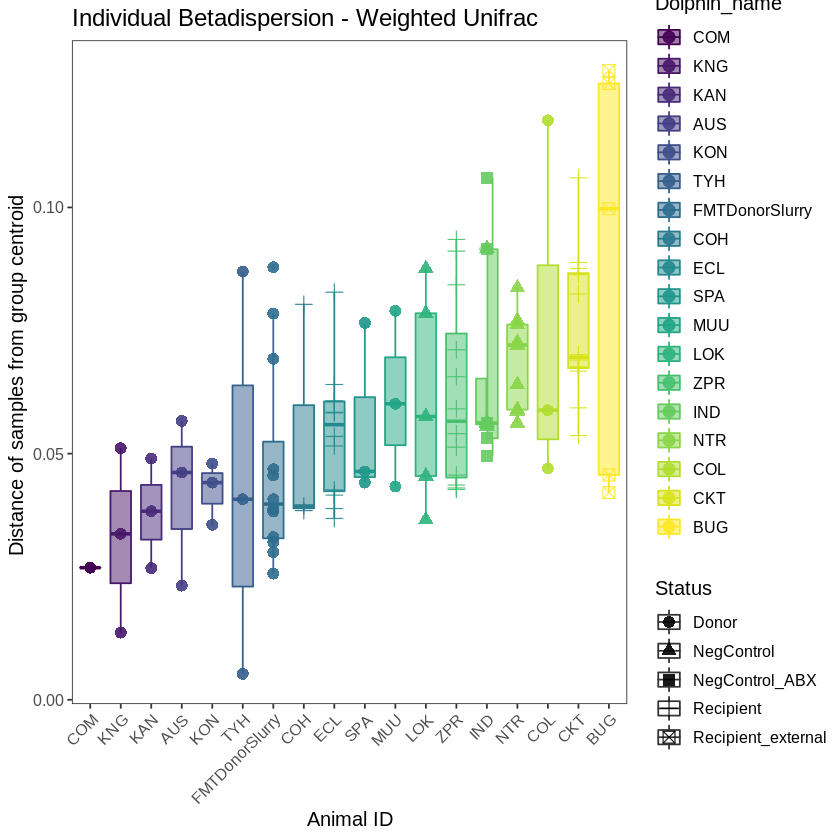

In [39]:
avg_obs <- aggregate(d ~ Dolphin_name, data = beta.disp.wuf2, mean)
beta.disp.wuf2$Dolphin_name <-factor(beta.disp.wuf2$Dolphin_name, levels=avg_obs[order(avg_obs$d), "Dolphin_name"])

wuf2.betadisper.kw = kruskal.test(d~Dolphin_name, data=beta.disp.wuf2)
wuf2.betadisper.kw

p = ggplot(beta.disp.wuf2, aes(x = Dolphin_name, y = d, fill = Dolphin_name, color = Dolphin_name, shape = Status)) + ggtitle("Individual Betadispersion - Weighted Unifrac")

p = p + geom_boxplot(outlier.stroke = 0.2, outlier.shape=20, alpha = 0.5) + 
        ylab("Distance of samples from group centroid ") + 
        xlab("Animal ID") +
        #scale_y_continuous(limits=c(0,0.15)) +
        scale_fill_viridis(discrete=TRUE)
        #scale_fill_manual(values=c("cadetblue1", "cadetblue4"))
        #coord_flip(ylim = c(0,0.15))

p = p + geom_point(size = 3, position = position_jitter(h = 0, w = 0), alpha = 0.9) +
    scale_color_viridis(discrete=TRUE)

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="right",
                           axis.text.x = element_text(angle = 45, hjust=1))
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))

p

png('/home/holutz/projects/DolphinMP/Phase2/Plots/dolphin_name.bdisp.wunif.viridis.png', width=6, height=5, units='in', res=300)
plot(p)
dev.off()


	Kruskal-Wallis rank sum test

data:  d by Dolphin_name
Kruskal-Wallis chi-squared = 38.285, df = 17, p-value = 0.002246


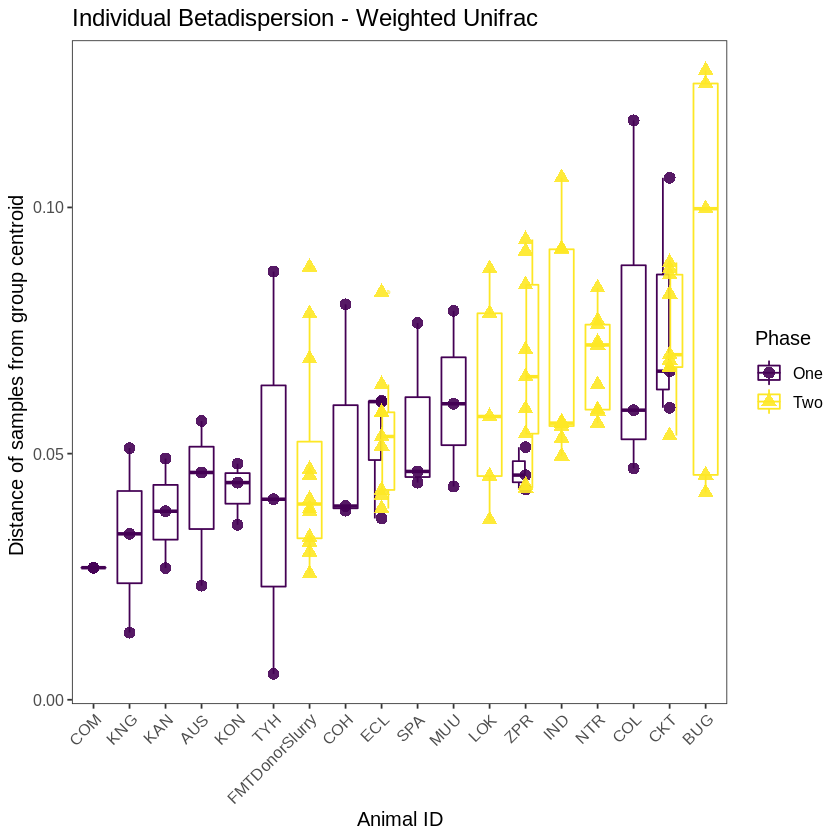

In [51]:
avg_obs <- aggregate(d ~ Dolphin_name, data = beta.disp.wuf2, mean)
beta.disp.wuf2$Dolphin_name <-factor(beta.disp.wuf2$Dolphin_name, levels=avg_obs[order(avg_obs$d), "Dolphin_name"])

wuf2.betadisper.kw = kruskal.test(d~Dolphin_name, data=beta.disp.wuf2)
wuf2.betadisper.kw

p = ggplot(beta.disp.wuf2, aes(x = Dolphin_name, y = d, color = Phase, shape = Phase)) + ggtitle("Individual Betadispersion - Weighted Unifrac")

p = p + geom_boxplot(outlier.stroke = 0.2, outlier.shape=20, alpha = 0.5) + 
        ylab("Distance of samples from group centroid ") + 
        xlab("Animal ID") +
        #scale_y_continuous(limits=c(0,0.15)) +
        scale_fill_viridis(discrete=TRUE)
        #scale_fill_manual(values=c("cadetblue1", "cadetblue4"))
        #coord_flip(ylim = c(0,0.15))

p = p + geom_point(size = 3, position = position_jitter(h = 0, w = 0), alpha = 0.9) +
    scale_color_viridis(discrete=TRUE)

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="right",
                           axis.text.x = element_text(angle = 45, hjust=1))
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))

#p = p + facet_wrap(~Dolphin_name)
p

In [45]:
dmp.dist.unif = distance(dmp_t, method = "unifrac", type = "samples")
dmp.dist.unif.log = ordinate(dmp_t, method = "PCoA", distance = "unifrac")
dmp.dist.unif.evals = dmp.dist.unif.log$values$Eigenvalues

sample_tab = (data.frame(sample_data(dmp_t)))

beta.disp.uf = betadisper(dmp.dist.unif,group = sample_data(dmp_t)$Dolphin_name)
beta.disp.uf = beta.disp.uf$distances
beta.disp.uf = data.frame(d = beta.disp.uf, sample_id = names(beta.disp.uf))
beta.disp.uf2 = left_join(beta.disp.uf, sample_tab, by="sample_id")

Warning message in matrix(tree$edge[order(tree$edge[, 1]), ][, 2], byrow = TRUE, :
“data length [7105] is not a sub-multiple or multiple of the number of rows [3553]”
Warning message in matrix(tree$edge[order(tree$edge[, 1]), ][, 2], byrow = TRUE, :
“data length [7105] is not a sub-multiple or multiple of the number of rows [3553]”



	Kruskal-Wallis rank sum test

data:  d by Dolphin_name
Kruskal-Wallis chi-squared = 41.094, df = 17, p-value = 0.0009049


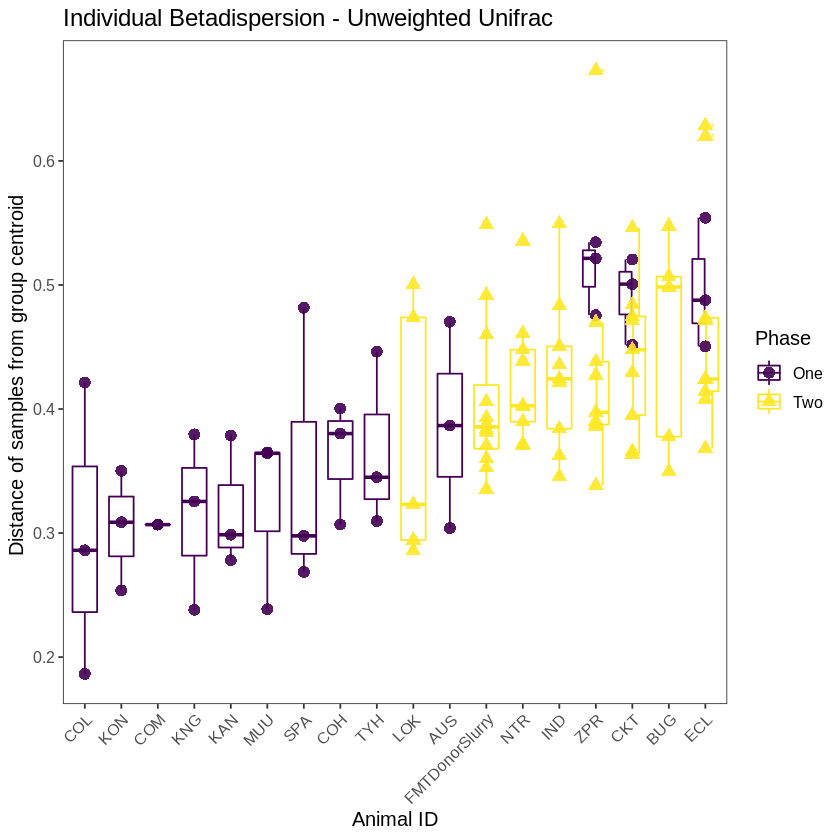

In [50]:
avg_obs <- aggregate(d ~ Dolphin_name, data = beta.disp.uf2, mean)
beta.disp.uf2$Dolphin_name <-factor(beta.disp.uf2$Dolphin_name, levels=avg_obs[order(avg_obs$d), "Dolphin_name"])

uf2.betadisper.k = kruskal.test(d~Dolphin_name, data=beta.disp.uf2)
uf2.betadisper.k

p = ggplot(beta.disp.uf2, aes(x = Dolphin_name, y = d, color = Phase, shape = Phase)) + ggtitle("Individual Betadispersion - Unweighted Unifrac")

p = p + geom_boxplot(outlier.stroke = 0.2, outlier.shape=20, alpha = 0.5) + 
        ylab("Distance of samples from group centroid ") + 
        xlab("Animal ID") +
        #scale_y_continuous(limits=c(0,0.15)) +
        scale_fill_viridis(discrete=TRUE)
        #scale_fill_manual(values=c("cadetblue1", "cadetblue4"))
        #coord_flip(ylim = c(0,0.15))

p = p + geom_point(size = 3, position = position_jitter(h = 0, w = 0), alpha = 0.9) +
    scale_color_viridis(discrete=TRUE)

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="right",
                           axis.text.x = element_text(angle = 45, hjust=1))
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))

#p = p + facet_wrap(~Dolphin_name)
p

In [56]:
head(beta.disp.uf2)
CKT = subset(beta.disp.uf2, Dolphin_name=="CKT")
ECL = subset(beta.disp.uf2, Dolphin_name=="ECL")
ZPR = subset(beta.disp.uf2, Dolphin_name=="ZPR")

recipient = rbind(CKT,ECL,ZPR)

,d,sample_id,Date,Dolphin_name,Animal_ID,Sample_number,Duplicate,Status,Age_years,Mass_lb,Sex,Phase,Exp_status
,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,0.2986441,SD103393,2/11/20,KAN,Dolphin G,Baseline_1,No,Donor,15,434,M,One,Donor_302
2,0.3501273,SD103842,2/27/20,KON,Dolphin I,Baseline_2,No,Donor,46,388,F,One,Donor_302
3,0.3068928,SD103847,2/27/20,COH,Dolphin C,Baseline_1,No,Recipient,36,388,F,One,Recipient_P1
4,0.4213448,SD102726,1/14/20,COL,Dolphin D,Baseline_1,No,Donor,19,531,M,One,Donor_122
5,0.5542029,SD103979,3/6/20,ECL,Dolphin F,Baseline_2,No,Recipient,6,358,M,One,Recipient_P1
6,0.4505009,SD102770,1/16/20,ECL,Dolphin F,Baseline_1,No,Recipient,6,358,M,One,Recipient_P1


png 
  2

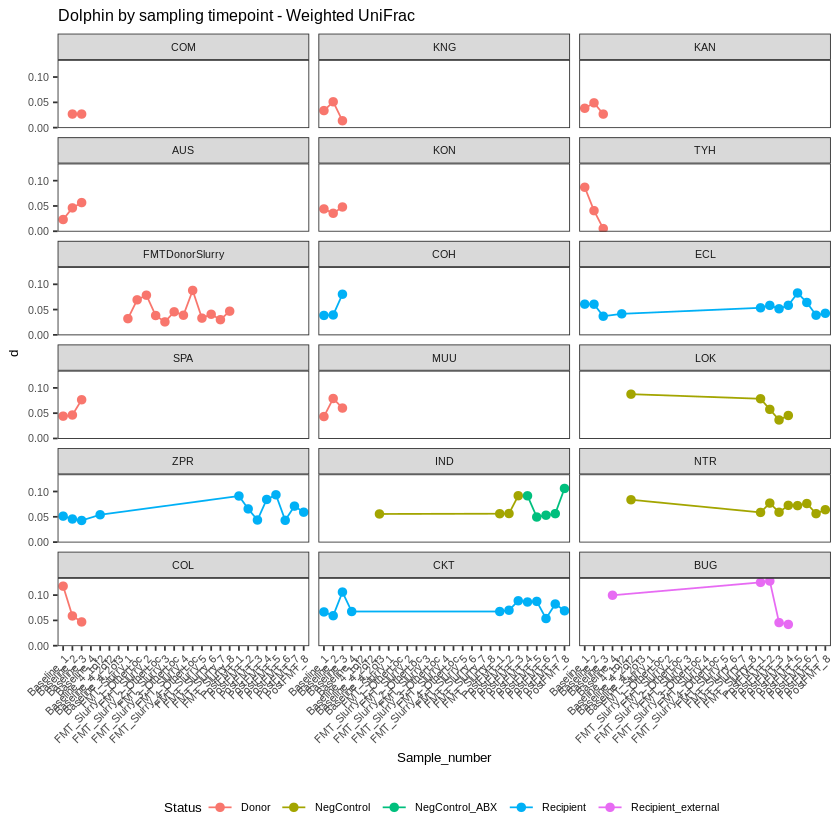

In [75]:
# Line plot with multiple groups
p = ggplot(data=beta.disp.wuf2, aes(x=Sample_number, y=d, group=Dolphin_name)) +
  geom_line(aes(color=Status))+
  geom_point(aes(color=Status),size=2) +
  ggtitle("Dolphin by sampling timepoint - Weighted UniFrac")

p = p + theme_bw() + theme(text=element_text(size=8, color="black",family = "Arial"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="bottom",
                           axis.text.x = element_text(angle = 45, hjust=1))
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))


p = p + facet_wrap(~Dolphin_name, ncol = 3)
p

png('/home/holutz/projects/DolphinMP/Phase2/Plots/name_by_timepoint.bdisp.wunif.png', width=10, height=10, units='in', res=300)
plot(p)
dev.off()

In [78]:
dmp2.t.mdf = psmelt(dmp_t)

In [88]:
donor = subset(dmp2.t.mdf, Status=="Donor")
recipient = subset(dmp2.t.mdf, Status=="Recipient")
control = subset(dmp2.t.mdf, Status=="NegControl")

dmp2.subset = rbind(donor,recipient,control)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Selecting by m

`summarise()` regrouping output by 'Sample_number', 'Phase', 'Status' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



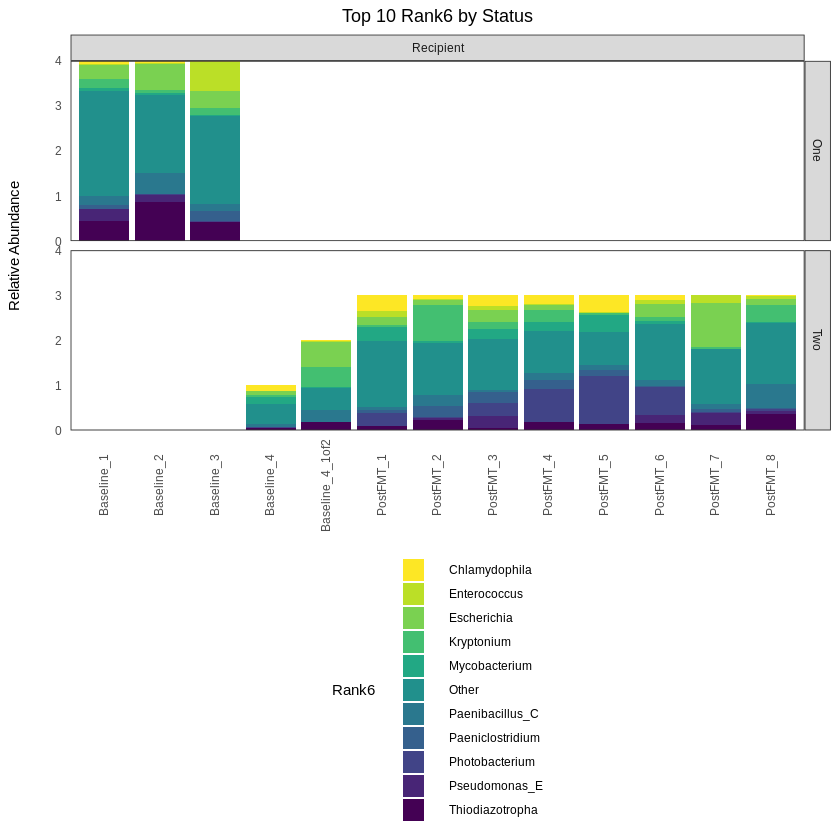

In [87]:
N = 10

topN = recipient %>%
    group_by(Rank6) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank6) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank6")

mdfall.other = recipient %>%
    mutate(Rank6.other = ifelse(Rank6 %in% topN, as.character(Rank6), "Other")) %>%
    group_by(Sample_number, Phase, Status, Rank6.other) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdfall.summary = mdfall.other %>%
    group_by(Rank6.other) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              abundance = round(avg*100,2)) %>%
    arrange(Rank6.other)

p = ggplot(mdfall.other[order(mdfall.other$Rank6.other),], aes(x=Sample_number, y = Abundance, fill = Rank6.other))
                        
p = p + facet_grid(Phase~Status) +#, shrink = TRUE, scales = "free_x",nrow=1) +
    ylab("Relative Abundance")  +
    geom_bar(stat="identity") +
    scale_fill_viridis(option="viridis", discrete=TRUE, direction=-1) +
    scale_y_continuous(expand = c(0,0))

p = p + guides(fill = guide_legend(title = "Rank6", ncol = 1, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=9, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              axis.text.x=element_text(angle=90,vjust=0.4),
              #legend.key.size = unit(.25, "mm"),
              legend.spacing.x = unit(.2,"in"),
              axis.title.x=element_blank())

p = p + theme(legend.position="bottom")

p = p + ggtitle("Top 10 Rank6 by Status") + theme(plot.title = element_text(hjust = 0.5))

p

#png('/home/holutz/projects/DolphinMP/Phase2/Plots/RelAbund.Status.Rank6.png', width=10, height=8, units='in', res=300)
#plot(p)
#dev.off()

### Alphadiversity

In [130]:
head(data.frame(sample_data(dolphin2_nt)))

,sample_id,Date,Dolphin_name,Animal_ID,Sample_number,Duplicate,Status,Age_years,Mass_lb,Sex,Phase,Exp_status
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
SD103393,SD103393,2/11/20,KAN,Dolphin G,Baseline_1,No,Donor,15,434,M,One,Donor_302
SD103842,SD103842,2/27/20,KON,Dolphin I,Baseline_2,No,Donor,46,388,F,One,Donor_302
SD103847,SD103847,2/27/20,COH,Dolphin C,Baseline_1,No,Recipient,36,388,F,One,Recipient_P1
SD102726,SD102726,1/14/20,COL,Dolphin D,Baseline_1,No,Donor,19,531,M,One,Donor_122
SD103979,SD103979,3/6/20,ECL,Dolphin F,Baseline_2,No,Recipient,6,358,M,One,Recipient_P1
SD102770,SD102770,1/16/20,ECL,Dolphin F,Baseline_1,No,Recipient,6,358,M,One,Recipient_P1


In [131]:
r0 = subset_samples(dolphin2_nt, Status=="Recipient")


r = subset_samples(r0, sample_id!="SD105731")
r2 = subset_samples(r, sample_id!="SD111901")
r3 = subset_samples(r2, sample_id!="SD112901")
r4 = subset_samples(r3, sample_id!="SD112268")


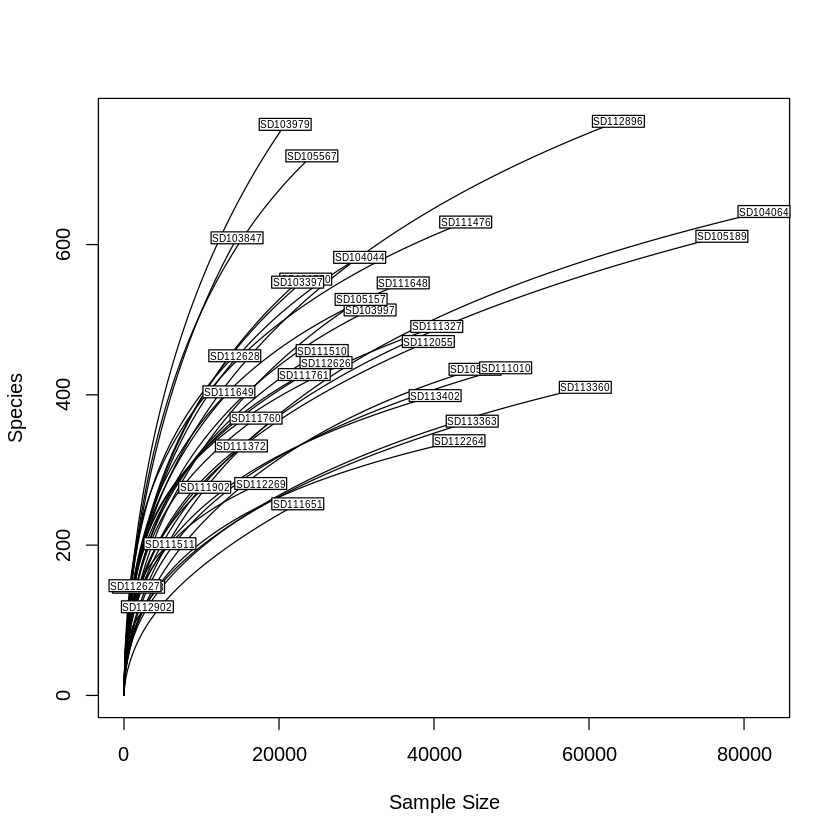

In [132]:
rarecurve(t(otu_table(r4)), step=100, cex=0.5)

In [123]:
head(data.frame(sample_data(dmp2.subset)))
colnames(data.frame(sample_data(dmp2.subset)))

,OTU,Sample,Abundance,sample_id,Date,Dolphin_name,Animal_ID,Sample_number,Duplicate,Status,⋯,Sex,Phase,Exp_status,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7
,<chr>,<chr>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
277076,G001403635,SD102726,0.5943634,SD102726,1/14/20,COL,Dolphin D,Baseline_1,No,Donor,⋯,M,One,Donor_122,Bacteria,Firmicutes_A,Clostridia,Clostridiales,Clostridiaceae,Clostridium_P,
353364,G001950115,SD113472,0.4085077,SD113472,4/28/21,FMTDonorSlurry,Mixed,FMT_Slurry_4_OtherLoc,No,Donor,⋯,Mixed,Two,Donor,Bacteria,Firmicutes_A,Clostridia,Peptostreptococcales,Peptostreptococcaceae,Paeniclostridium,Paeniclostridium sordellii
33519,G000154485,SD105589,0.3828615,SD105589,7/6/20,SPA,Dolphin K,Baseline_3,No,Donor,⋯,M,One,Donor_122,Bacteria,Firmicutes,Bacilli,Erysipelotrichales,Erysipelatoclostridiaceae,Erysipelatoclostridium,Erysipelatoclostridium ramosum
307191,G001536085,SD113470,0.3318187,SD113470,4/14/21,FMTDonorSlurry,Mixed,FMT_Slurry_2_OtherLoc,No,Donor,⋯,Mixed,Two,Donor,Bacteria,Bacteroidota,Kryptonia,Kryptoniales,Kryptoniaceae,Kryptonium,Kryptonium thompsoni
297269,G001442935,SD113470,0.3288037,SD113470,4/14/21,FMTDonorSlurry,Mixed,FMT_Slurry_2_OtherLoc,No,Donor,⋯,Mixed,Two,Donor,Bacteria,Bacteroidota,Kryptonia,Kryptoniales,Kryptoniaceae,Kryptonium,Kryptonium thompsoni
50365,G000176795,SD105560,0.3128415,SD105560,7/4/20,MUU,Dolphin J,Baseline_1,No,Donor,⋯,F,One,Donor_302,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Photobacterium,Photobacterium damselae


[1] "OTU"           "Sample"        "Abundance"     "sample_id"    
 [5] "Date"          "Dolphin_name"  "Animal_ID"     "Sample_number"
 [9] "Duplicate"     "Status"        "Age_years"     "Mass_lb"      
[13] "Sex"           "Phase"         "Exp_status"    "Rank1"        
[17] "Rank2"         "Rank3"         "Rank4"         "Rank5"        
[21] "Rank6"         "Rank7"

In [98]:
donor = subset_samples(dolphin2_nt, Status=="Donor")
recipient = subset_samples(dolphin2_nt, Status=="Recipient")
control = subset_samples(dolphin2_nt, Status=="NegControl")

dmp_nt.subset = merge_phyloseq(donor,recipient,control)

#### Shannon Index

In [100]:
sha = estimate_richness(dmp_nt.subset, split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)
sha[] <- lapply(sha, gsub, pattern='X', replacement='') #Remove X from SampleID name

sample_tab = data.frame(sample_data(dmp_nt.subset))
names(sample_tab)[1] = "SampleID"

dfsha = merge(sha, sample_tab, on="SampleID")

dfsha$Shannon = as.numeric(dfsha$Shannon)

stats = dfsha %>%
    group_by(Status) %>%
    summarize(median = median(Shannon),
              mean = mean(Shannon),
              sd = sd(Shannon),
              sem = sd(Shannon/sqrt(length(Shannon)))) %>%
    arrange(-desc(mean))
stats

stats.krusk = kruskal.test(Shannon~Status, data=dfsha)
stats.krusk

`summarise()` ungrouping output (override with `.groups` argument)



Status,median,mean,sd,sem
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
NegControl,2.720563,2.650863,0.8235366,0.1941094
Recipient,3.346220,3.198598,0.7555989,0.1209927
Donor,3.351331,3.218673,0.6273724,0.1017732



	Kruskal-Wallis rank sum test

data:  Shannon by Status
Kruskal-Wallis chi-squared = 7.6584, df = 2, p-value = 0.02173


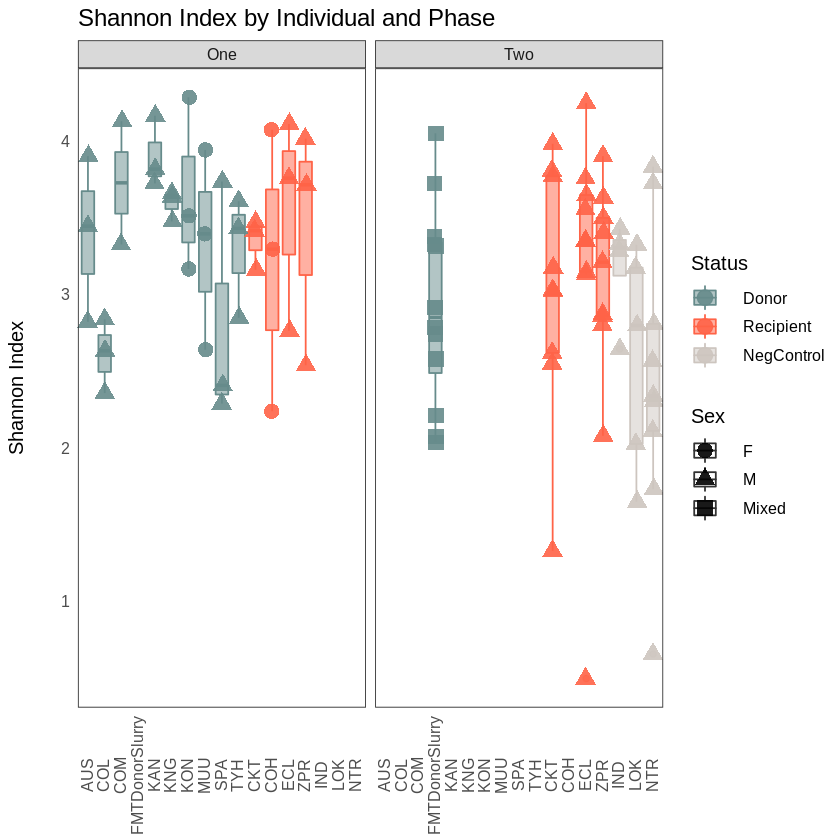

In [107]:
p = ggplot(dfsha, aes(x = Dolphin_name, y = Shannon, fill=Status, color=Status, shape = Sex)) + ggtitle("Shannon Index by Individual and Phase")

p = p + geom_boxplot(alpha = 0.5) + ylab("Shannon Index") +
    scale_fill_manual(values=c("paleturquoise4","tomato","seashell3"))

p = p + geom_point(size = 4, position = position_jitter(h = 0, w = 0.05), alpha = 0.9) +
    scale_color_manual(values=c("paleturquoise4","tomato","seashell3"))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=12, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              axis.text.x=element_text(angle=90,vjust=0.4),
              #legend.key.size = unit(.25, "mm"),
              legend.spacing.x = unit(.2,"in"),
              axis.title.x=element_blank())

p = p + facet_wrap(~Phase)

p

#png('/home/holutz/projects/DolphinMP/Phase1/Plots/ShannonIndex.dolphin_name.boxplot.png', width=6, height=6, units='in', res=300)
#plot(p)
#dev.off()

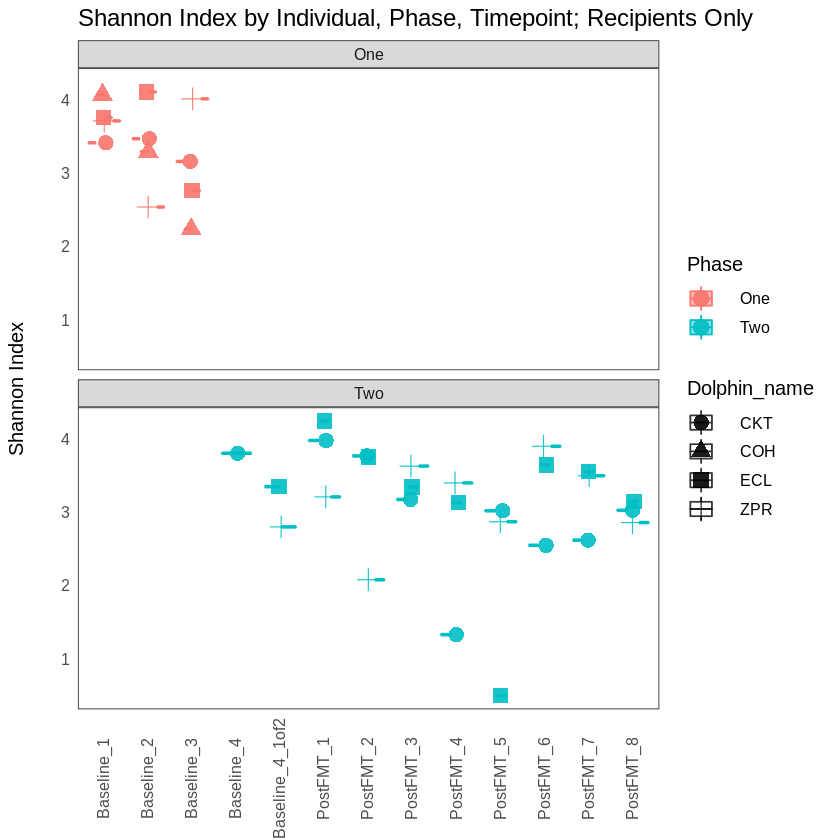

In [112]:
dfsha_subset = subset(dfsha, Status=="Recipient")

p = ggplot(dfsha_subset, aes(x = Sample_number, y = Shannon, fill=Phase, color=Phase, shape = Dolphin_name)) + ggtitle("Shannon Index by Individual, Phase, Timepoint; Recipients Only")

p = p + geom_boxplot(alpha = 0.5) + ylab("Shannon Index")# +
  #  scale_fill_manual(values=c("tomato"))

p = p + geom_point(size = 4, position = position_jitter(h = 0, w = 0.05), alpha = 0.9) #+
  #  scale_color_manual(values=c("tomato"))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=12, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              axis.text.x=element_text(angle=90,vjust=0.4),
              #legend.key.size = unit(.25, "mm"),
              legend.spacing.x = unit(.2,"in"),
              axis.title.x=element_blank())

p = p + facet_wrap(~Phase, nrow=2)

p

#png('/home/holutz/projects/DolphinMP/Phase1/Plots/ShannonIndex.dolphin_name.boxplot.png', width=6, height=6, units='in', res=300)
#plot(p)
#dev.off()

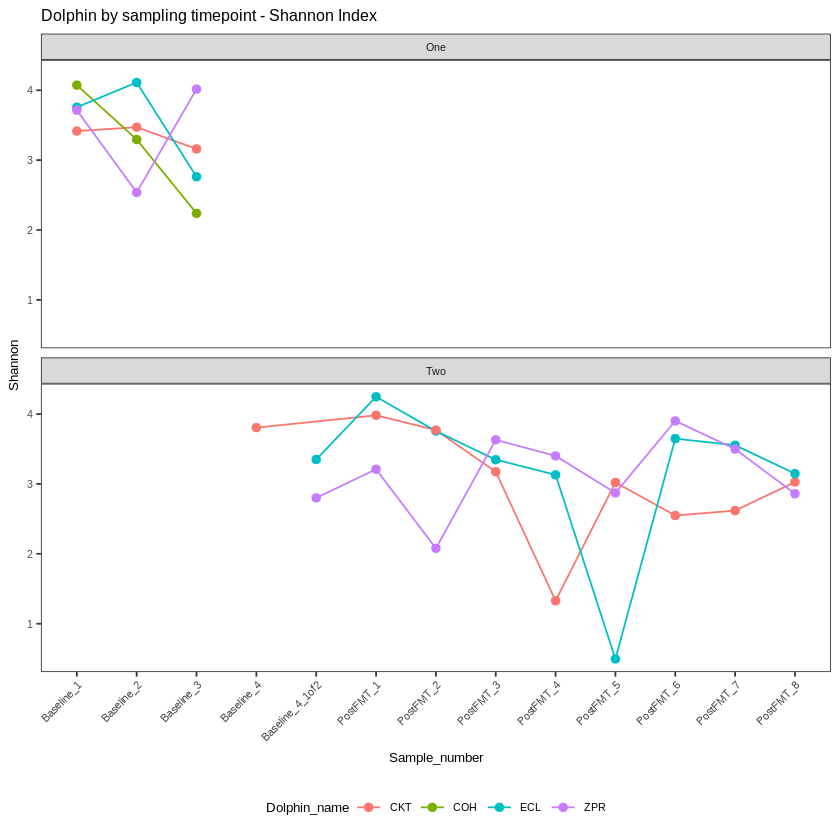

In [116]:
# Line plot with multiple groups
p = ggplot(data=dfsha_subset, aes(x=Sample_number, y=Shannon, group=Dolphin_name)) +
  geom_line(aes(color=Dolphin_name))+
  geom_point(aes(color=Dolphin_name),size=2) +
  ggtitle("Dolphin by sampling timepoint - Shannon Index")

p = p + theme_bw() + theme(text=element_text(size=8, color="black",family = "Arial"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="bottom",
                           axis.text.x = element_text(angle = 45, hjust=1))
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))


p = p + facet_wrap(~Phase, nrow = 2)
p

#png('/home/holutz/projects/DolphinMP/Phase2/Plots/name_by_timepoint.bdisp.wunif.png', width=10, height=10, units='in', res=300)
#plot(p)
#dev.off()

#### Observed Richness

In [117]:
obs = estimate_richness(dmp_nt.subset, split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)
obs[] <- lapply(obs, gsub, pattern='X', replacement='') #Remove X from SampleID name

sample_tab = data.frame(sample_data(dmp_nt.subset))
names(sample_tab)[1] = "SampleID"

dfobs = merge(obs, sample_tab, on="SampleID")

dfobs$Observed = as.numeric(dfobs$Observed)

stats = dfobs %>%
    group_by(Status) %>%
    summarize(median = median(Observed),
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) %>%
    arrange(-desc(mean))
stats

stats.krusk = kruskal.test(Observed~Status, data=dfobs)
stats.krusk

`summarise()` ungrouping output (override with `.groups` argument)



Status,median,mean,sd,sem
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
NegControl,384,464.5556,262.4922,61.87000
Recipient,459,507.1026,242.2745,38.79497
Donor,530,633.7895,318.4927,51.66633



	Kruskal-Wallis rank sum test

data:  Observed by Status
Kruskal-Wallis chi-squared = 8.8744, df = 2, p-value = 0.01183


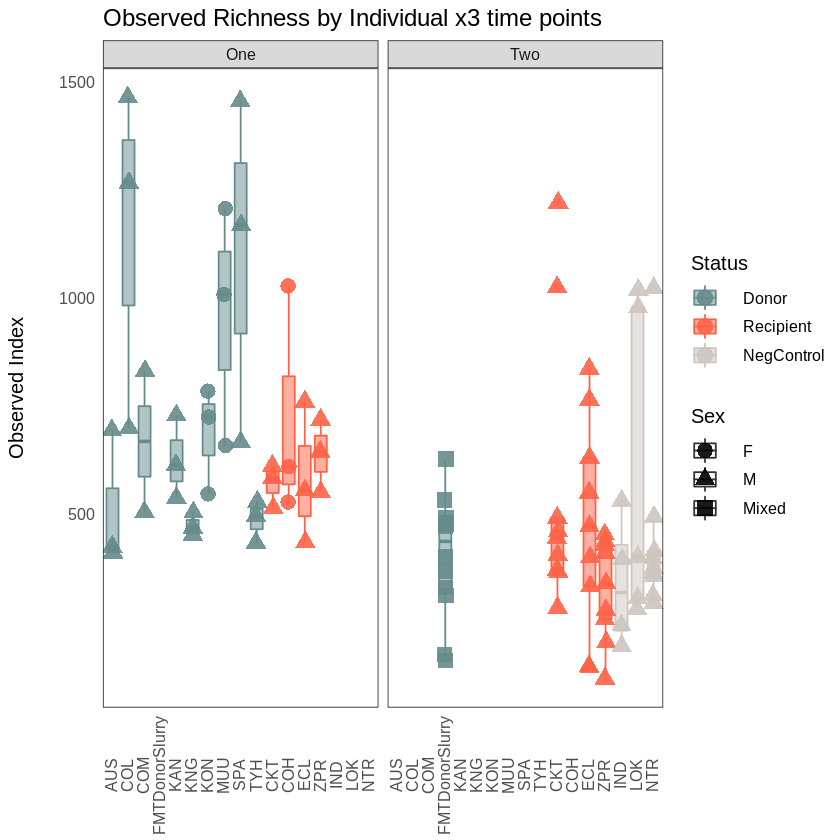

In [118]:
p = ggplot(dfobs, aes(x = Dolphin_name, y = Observed, fill=Status, color=Status, shape = Sex)) + ggtitle("Observed Richness by Individual x3 time points")

p = p + geom_boxplot(alpha = 0.5) + ylab("Observed Index") +
    scale_fill_manual(values=c("paleturquoise4","tomato","seashell3"))

p = p + geom_point(size = 4, position = position_jitter(h = 0, w = 0.05), alpha = 0.9) +
    scale_color_manual(values=c("paleturquoise4","tomato","seashell3"))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=12, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              axis.text.x=element_text(angle=90,vjust=0.4),
              #legend.key.size = unit(.25, "mm"),
              legend.spacing.x = unit(.2,"in"),
              axis.title.x=element_blank())

p = p + facet_wrap(~Phase)

p

#png('/home/holutz/projects/DolphinMP/Phase1/Plots/ObservedIndex.dolphin_name.boxplot.png', width=6, height=6, units='in', res=300)
#plot(p)
#dev.off()

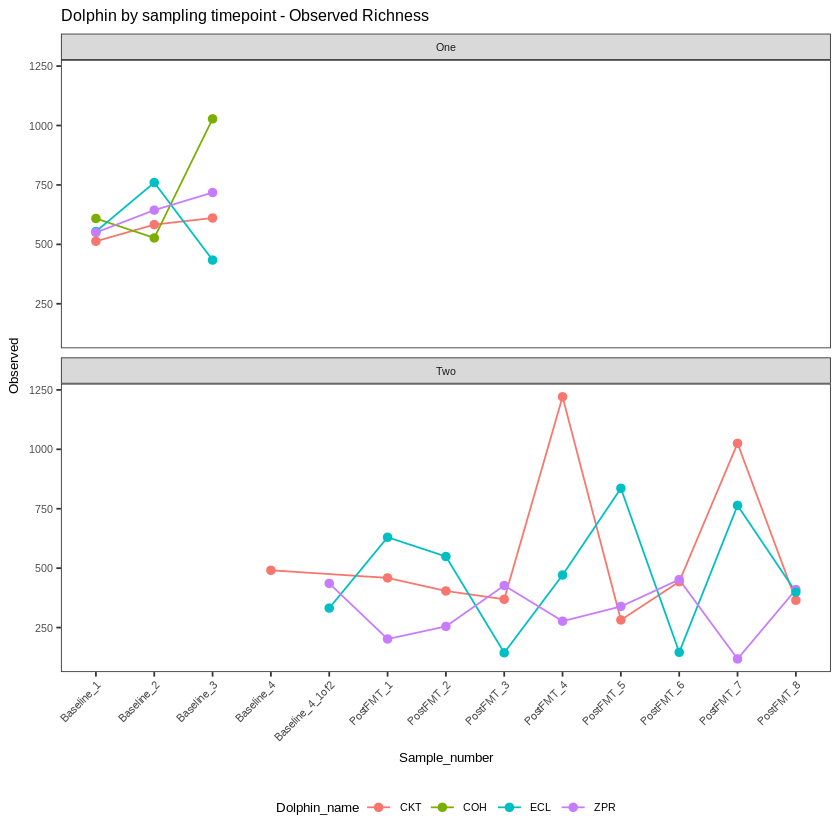

In [120]:
dfobs_subset = subset(dfobs, Status=="Recipient")

# Line plot with multiple groups
p = ggplot(data=dfobs_subset, aes(x=Sample_number, y=Observed, group=Dolphin_name)) +
  geom_line(aes(color=Dolphin_name))+
  geom_point(aes(color=Dolphin_name),size=2) +
  ggtitle("Dolphin by sampling timepoint - Observed Richness")

p = p + theme_bw() + theme(text=element_text(size=8, color="black",family = "Arial"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="bottom",
                           axis.text.x = element_text(angle = 45, hjust=1))
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))


p = p + facet_wrap(~Phase, nrow = 2)
p

#png('/home/holutz/projects/DolphinMP/Phase2/Plots/name_by_timepoint.bdisp.wunif.png', width=10, height=10, units='in', res=300)
#plot(p)
#dev.off()